In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import scanpy.api as sc
from igraph import *
from MulticoreTSNE import MulticoreTSNE as TSNE #faster TSNE alternative
from anndata import read_h5ad
from anndata import read_csv
import bbknn
import leidenalg
sc.logging.print_versions()

scanpy==1.4+323.g0401341 anndata==0.6.19+16.g34f4eb6 numpy==1.15.0 scipy==1.2.1 pandas==0.24.1 scikit-learn==0.22.dev0 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


# Import MACA facs data

## Import tabula-muris (3m)

In [ ]:
tm_facs_metadata = pd.read_csv('/data/maca/data/facs3mo/TM_facs_metadata.csv')
tm_facs_metadata.head()

In [ ]:
tm_facs_metadata.loc[tm_facs_metadata['cell']=='I4.D042180.3_10_M.1.1'] #I4-D042180-3_10_M-1-1

In [ ]:
tm_facs_metadata = pd.read_csv('/data/maca/data/facs3mo/TM_facs_metadata.csv',usecols = ['cell','tissue','subtissue','mouse.sex','mouse.id','method','cell_ontology_class','cell_ontology_id','free_annotation'])
tm_facs_metadata = tm_facs_metadata.rename(columns = {'mouse.sex':'sex'})
display(tm_facs_metadata.head())
tm_facs_metadata['cell_index'] = tm_facs_metadata['cell']
tm_facs_metadata = tm_facs_metadata.set_index('cell_index')
tm_facs_metadata.tail()

In [ ]:
tm_facs_data = read_h5ad('/data/maca/data/facs3mo/TM_facs_mat.h5ad')
tm_facs_data

In [ ]:
tm_facs_data.obs = tm_facs_metadata
tm_facs_data.obs['age'] = '3m'

tm_facs_data.obs['sex'] = tm_facs_data.obs['sex'].replace({'M':'male', 'F':'female'})
tm_facs_data.obs.head()

In [ ]:
ercc_genes = [name for name in tm_facs_data.var_names if name.startswith('ERCC-')]
tm_facs_data = tm_facs_data[:,~tm_facs_data.var_names.isin(ercc_genes)]

In [ ]:
tm_facs_data

In [ ]:
tm_facs_data.write_loom('./write/tabula-muris-facs.loom')

## Create 24m FACS data object

In [ ]:
facs24metadata = pd.read_csv('/data/maca/data/facs24mo/MACA_Metadata.csv',
                             usecols = [' ','tissue','subtissue','mouse.sex','mouse.id','mouse.age','FACS.selection'])
facs24metadata = facs24metadata.rename(columns = {' ':'plate','mouse.age':'age','mouse.sex':'sex','mouse.id':'mouseid'})
facs24metadata = facs24metadata.set_index('plate')
facs24metadata.head()

In [ ]:
set(facs24metadata['FACS.selection'])                        

In [ ]:
facs24metadata.loc['B003226']

In [ ]:
echopick1 = pd.read_csv('/data/maca/data/facs24mo/96wellmetadata/echo_picklist_00001.csv',
                       usecols = ['Source well','Plate number','Name','Destination well'])
echopick1 = echopick1.rename(columns = {'Plate number':'echo_plate','Source well':'echo_plate_wells'})
echopick2 = pd.read_csv('/data/maca/data/facs24mo/96wellmetadata/echo_picklist_00002.csv',
                       usecols = ['Source well','Plate number','Name','Destination well'])
echopick2 = echopick2.rename(columns = {'Plate number':'echo_plate','Source well':'echo_plate_wells'})
echopick3 = pd.read_csv('/data/maca/data/facs24mo/96wellmetadata/echo_picklist_00003_incomplete.csv',
                       usecols = ['Source well','Plate number','Name','Destination well'])
echopick3 = echopick3.rename(columns = {'Plate number':'echo_plate','Source well':'echo_plate_wells'})

for i in range(0,len(echopick1)):
    if len(list(echopick1.echo_plate_wells[i])) == 2:
        echopick1.echo_plate_wells[i] = list(echopick1.echo_plate_wells[i])[0] + '0' + list(echopick1.echo_plate_wells[i])[1]
echopick1['name'] = echopick1['echo_plate_wells']+'-'+echopick1['echo_plate']+'-NA-1'
echopick1['destination_plate'] = 'B008782'
echopick1['cellid'] = echopick1['Destination well']+'_'+echopick1['destination_plate']

for i in range(0,len(echopick2)):
    if len(list(echopick2.echo_plate_wells[i])) == 2:
        echopick2.echo_plate_wells[i] = list(echopick2.echo_plate_wells[i])[0] + '0' + list(echopick2.echo_plate_wells[i])[1]
echopick2['name'] = echopick2['echo_plate_wells']+'-'+echopick2['echo_plate']+'-NA-1'
echopick2['destination_plate'] = 'B008781'
echopick2['cellid'] = echopick2['Destination well']+'_'+echopick2['destination_plate']

for i in range(0,len(echopick3)):
    if len(list(echopick3.echo_plate_wells[i])) == 2:
        echopick3.echo_plate_wells[i] = list(echopick3.echo_plate_wells[i])[0] + '0' + list(echopick3.echo_plate_wells[i])[1]
echopick3['name'] = echopick3['echo_plate_wells']+'-'+echopick3['echo_plate']+'-NA-1'
echopick3['destination_plate'] = 'B008659'
echopick3['cellid'] = echopick3['Destination well']+'_'+echopick3['destination_plate']

In [ ]:
display(echopick1.head())
display(echopick2.head())
display(echopick3.head())

In [ ]:
echoplateformats = pd.read_csv('/data/maca/data/facs24mo/96wellmetadata/96well_data.csv')
echoplateformats['name'] = echoplateformats['echo_plate_wells']+'-'+echoplateformats['echo_plate']+'-NA-1'

In [ ]:
echoplateformats.head(10)

In [ ]:
echoreformatkey = pd.concat([echopick1,echopick2,echopick3])
echoreformatkey.head()

In [ ]:
echoreformatkey2 = pd.merge(echoreformatkey,echoplateformats, how='inner', on='name')
display(len(echoreformatkey2))

In [ ]:
echoreformatkey2.head()

In [ ]:
echoreformatkey2.shape

In [ ]:
for i in range(0,len(echoreformatkey2)):
    
    baux = list(echoreformatkey2['cDNA_plate_well'][i].split()[0])
    if len(baux) == 2:
        echoreformatkey2['cDNA_plate_well'][i] = baux[1]+baux[0]
           
    if len(baux) == 3:
        echoreformatkey2['cDNA_plate_well'][i] = baux[2]+baux[0]+baux[1]

In [ ]:
echoreformatkey2.head()

In [ ]:
echoreformatkey2['cell.id'] = echoreformatkey2['cDNA_plate_well']+'_'+echoreformatkey2['cDNA_plate']
echoreformatkey2.head()

In [ ]:
cdnametadata = pd.read_csv('/data/maca/data/facs24mo/96wellmetadata/24m_96well_metadata_all.csv')
cdnametadata.head()

In [ ]:
metadata96well = pd.merge(echoreformatkey2,cdnametadata, how='inner', on='cell.id')

In [ ]:
set(metadata96well['Tissue'])

In [ ]:
metadata96well.head()

In [ ]:
metadata96well.to_csv('./write/metadata96well.csv')

In [ ]:
facs24metadata96well = metadata96well[['Tissue', 'Subtissue', 'mouse.id','destination_plate','cellid','Sort']].copy()

In [ ]:
facs24metadata96well = facs24metadata96well.rename(
    columns = {'Tissue':'tissue','Subtissue':'subtissue','destination_plate':'plate','Sort':'FACS.selection'})
# facs24metadata96well = facs24metadata96well.set_index('plate')
facs24metadata96well['age'] = '24m'
facs24metadata96well['sex'] = 'male'
facs24metadata96well.head()

In [ ]:
facs24metadata96well.to_csv('./write/facs24metadata96well.csv')
len(facs24metadata96well)

In [ ]:
run180918metadata = pd.read_csv('/data/maca/data/facs24mo/180918_metadata_key.csv')
run180918metadata['cDNA_plate'][4]='B001157'
run180918metadata = dict(zip(run180918metadata.cDNA_plate,run180918metadata.library_plate))
run180918metadata

In [ ]:
import os
from scipy import sparse

runs = [x[1] for x in os.walk('/data/maca/data/facs24mo/')][0]
runs.remove('vcf')
runs.remove('96wellmetadata')
runs.remove('180813_A00111_0188_AH7G2FDSXX')

facs24 = []
for r in runs:
    
    path = '/data/maca/data/facs24mo/'+ r +'/'+ r +'.csv'
    
    facs24_aux = read_csv(path)
    facs24_aux = facs24_aux.transpose()
    facs24_aux.obs['plate'] = [i.split('_')[1] for i in facs24_aux.obs.index] 
    facs24_aux.obs['well'] = [i.split('_')[0] for i in facs24_aux.obs.index]
    facs24_aux.obs['method'] = 'facs'

    myList = list(set(facs24_aux.obs['plate']))
    
    if r == '180918_A00111_0213_BHGKTWDMXX':
        auxdict = dict(facs24metadata['tissue'][run180918metadata.keys()])
        changedDict = {}
        for key, value in auxdict.items():
            changedDict[run180918metadata[key]] = value
        facs24_aux.obs['tissue'] = facs24_aux.obs['plate'].map(changedDict)
        
        auxdict = dict(facs24metadata['subtissue'][run180918metadata.keys()])
        changedDict = {}
        for key, value in auxdict.items():
            changedDict[run180918metadata[key]] = value
        facs24_aux.obs['subtissue'] = facs24_aux.obs['plate'].map(changedDict)
        
        auxdict = dict(facs24metadata['sex'][run180918metadata.keys()])
        changedDict = {}
        for key, value in auxdict.items():
            changedDict[run180918metadata[key]] = value
        facs24_aux.obs['sex'] = facs24_aux.obs['plate'].map(changedDict)
        
        auxdict = dict(facs24metadata['age'][run180918metadata.keys()])
        changedDict = {}
        for key, value in auxdict.items():
            changedDict[run180918metadata[key]] = value
        facs24_aux.obs['age'] = facs24_aux.obs['plate'].map(changedDict)
        
        auxdict = dict(facs24metadata['mouseid'][run180918metadata.keys()])
        changedDict = {}
        for key, value in auxdict.items():
            changedDict[run180918metadata[key]] = value
        facs24_aux.obs['mouse.id'] = facs24_aux.obs['plate'].map(changedDict)
        
        auxdict = dict(facs24metadata['FACS.selection'][run180918metadata.keys()])
        changedDict = {}
        for key, value in auxdict.items():
            changedDict[run180918metadata[key]] = value
        facs24_aux.obs['FACS.selection'] = facs24_aux.obs['plate'].map(changedDict)
        
        print('import complete for run '+r)

    else:
        try:
            auxdict = dict(facs24metadata['tissue'][myList])
            facs24_aux.obs['tissue'] = facs24_aux.obs['plate'].map(auxdict)
            auxdict = dict(facs24metadata['subtissue'][myList])
            facs24_aux.obs['subtissue'] = facs24_aux.obs['plate'].map(auxdict)
            auxdict = dict(facs24metadata['sex'][myList])
            facs24_aux.obs['sex'] = facs24_aux.obs['plate'].map(auxdict)
            auxdict = dict(facs24metadata['age'][myList])
            facs24_aux.obs['age'] = facs24_aux.obs['plate'].map(auxdict)
            auxdict = dict(facs24metadata['mouseid'][myList])
            facs24_aux.obs['mouse.id'] = facs24_aux.obs['plate'].map(auxdict)
            auxdict = dict(facs24metadata['FACS.selection'][myList])
            facs24_aux.obs['FACS.selection'] = facs24_aux.obs['plate'].map(auxdict)
            print('import complete for run '+r)
        except KeyError:
            print('sorry, no metadata available for run '+r)
    
    facs24.append(facs24_aux)

first = facs24.pop()
facs24 = first.concatenate(facs24)

facs24.obs['sex'] = facs24.obs['sex'].replace({'M':'male', 'F':'female'})

# for i in facs24.obs.index:
#     if facs24.obs.loc[i,'FACS.selection'] == 'Neurons':
#         facs24.obs.loc[i,'tissue'] = 'Brain_Non-Myeloid'
#     else:
#         if facs24.obs.loc[i,'FACS.selection'] == 'Microglia':
#             facs24.obs.loc[i,'tissue'] = 'Brain_Myeloid'

facs24.obs['tissue'] = facs24.obs['tissue'].replace({'Colon':'Large_Intestine'})
facs24.obs['tissue'] = facs24.obs['tissue'].replace({'Muscle':'Limb_Muscle'})
facs24.obs['tissue'] = facs24.obs['tissue'].replace({'Mammary':'Mammary_Gland'})

facs24.obs['age'] = facs24.obs['age'].replace({'24':'24m'})
facs24.obs['cell_ontology_class'] = 'NA'
facs24.obs['free_annotation'] = 'NA'

ercc_genes = [name for name in facs24.var_names if name.startswith('ERCC-')]
facs24 = facs24[:,~facs24.var_names.isin(ercc_genes)]

non_genes = [name for name in facs24.var_names if name.startswith('_')]
facs24 = facs24[:,~facs24.var_names.isin(non_genes)]

facs24.X = sparse.csr_matrix(facs24.X)

facs24    

In [ ]:
for i in facs24.obs.index:
    if facs24.obs.loc[i,'FACS.selection'] == 'Neurons':
        facs24.obs.loc[i,'tissue'] = 'Brain_Non-Myeloid'
    else:
        if facs24.obs.loc[i,'FACS.selection'] == 'Microglia':
            facs24.obs.loc[i,'tissue'] = 'Brain_Myeloid'

In [ ]:
facs24.obs['cellid'] = facs24.obs['well']+'_'+facs24.obs['plate']
facs24.obs.head()

In [ ]:
set(facs24.obs['tissue'])

In [ ]:
# nantissue = facs24.obs[facs24.obs['tissue'].isna()]
# nantissue.to_csv('./write/spookynantissues.csv')

In [ ]:
# nantissue = facs24.obs[facs24.obs['tissue'].isna()]
# display(set(nantissue['plate']))
# len(facs24.obs[facs24.obs['tissue'].isna()])

In [ ]:
for ci in facs24metadata96well['cellid']:
    try:
        facs24.obs.loc[facs24.obs[facs24.obs['cellid']==ci].index.item(),'tissue'] = list(
            facs24metadata96well[facs24metadata96well.cellid==ci]['tissue'])[0]
        
        facs24.obs.loc[facs24.obs[facs24.obs['cellid']==ci].index.item(),'subtissue'] = list(
            facs24metadata96well[facs24metadata96well.cellid==ci]['subtissue'])[0]
        
        facs24.obs.loc[facs24.obs[facs24.obs['cellid']==ci].index.item(),'sex'] = list(
            facs24metadata96well[facs24metadata96well.cellid==ci]['sex'])[0]
        
        facs24.obs.loc[facs24.obs[facs24.obs['cellid']==ci].index.item(),'age'] = list(
            facs24metadata96well[facs24metadata96well.cellid==ci]['age'])[0]
        
        facs24.obs.loc[facs24.obs[facs24.obs['cellid']==ci].index.item(),'mouse.id'] = list(
            facs24metadata96well[facs24metadata96well.cellid==ci]['mouse.id'])[0]
        
        facs24.obs.loc[facs24.obs[facs24.obs['cellid']==ci].index.item(),'FACS.selection'] = list(
            facs24metadata96well[facs24metadata96well.cellid==ci]['FACS.selection'])[0]
    
    except ValueError:
            print('sorry, no cell with id '+ci)
 

In [ ]:
nantissue = facs24.obs[facs24.obs['tissue'].isna()]
display(set(nantissue['plate']))
len(facs24.obs[facs24.obs['tissue'].isna()])

In [ ]:
facs24.write('./write/maca-facs-24-raw.h5ad')

In [ ]:
import gc
gc.collect()

## Import 24m FACS data

In [ ]:
facs24 = read_h5ad('../anndata-objs/maca-facs-24-raw.h5ad')
facs24

## Import 18m and 21m mammary gland FACS data

In [ ]:
facs1821mammary = read_csv('/data/maca/data/facs18m21m/181207_A00111_0239_BH3WNVDRXX.csv')
facs1821mammary = facs1821mammary.transpose()
facs1821mammary.obs['plate'] = [i.split('_')[1] for i in facs1821mammary.obs_names] 
facs1821mammary.obs['well'] = [i.split('_')[0] for i in facs1821mammary.obs_names]
facs1821mammary.obs['method'] = 'facs'
facs1821mammary.obs['tissue'] = 'Mammary_Gland'
facs1821mammary.obs['subtissue'] = 'Mammary_Gland'
facs1821mammary.obs['sex'] = 'female'
facs1821mammary.obs['cell_ontology_class'] = 'NA'
facs1821mammary.obs['cell_ontology_id'] = 'NA'
facs1821mammary.obs['free_annotation'] = 'NA'
facs1821mammary.obs['FACS.selction'] = 'Multiple'

In [ ]:
facs1821mammary_metadata = pd.read_csv('/data/maca/data/facs18m21m/MammaryGlandMetaData.csv')
facs1821mammary_metadata

In [ ]:
facs1821mammary_dict_age = {}
facs1821mammary_dict_mouseid = {}
for i in range(0,len(facs1821mammary_metadata)):
    facs1821mammary_dict_age[facs1821mammary_metadata['Plate ID'][i]] = facs1821mammary_metadata['Mouse_ID'][i].split('_')[0]
    facs1821mammary_dict_mouseid[facs1821mammary_metadata['Plate ID'][i]] = facs1821mammary_metadata['Mouse_ID'][i]
facs1821mammary_dict_age,facs1821mammary_dict_mouseid

In [ ]:
facs1821mammary.obs_names

In [ ]:
facs1821mammary.obs['cell'] = facs1821mammary.obs_names

facs1821mammary.obs['mouse.id'] = facs1821mammary.obs['plate'].map(facs1821mammary_dict_mouseid)

facs1821mammary.obs['age'] = facs1821mammary.obs['plate'].map(facs1821mammary_dict_age)
facs1821mammary.obs['age'] = facs1821mammary.obs['age'] + 'm'
facs1821mammary.obs.head()

In [ ]:
ercc_genes = [name for name in facs1821mammary.var_names if name.startswith('ERCC-')]
facs1821mammary = facs1821mammary[:,~facs1821mammary.var_names.isin(ercc_genes)]

In [ ]:
facs1821mammary

In [ ]:
facs1821mammary.write('../anndata-objs/maca-facs-mammary-18-21-raw.h5ad')

# Combine all FACS data and write the object

In [ ]:
adata = facs24.concatenate(tm_facs_data,facs1821mammary)
adata.write('../anndata-objs/maca-facs-raw-data-all-ages.h5ad')
adata

# Import MACA FACS raw data

In [ ]:
adata = read_h5ad('../anndata-objs/maca-facs-raw-data-all-ages.h5ad')
adata

In [ ]:
raw_cell_counts = adata.obs.groupby(['tissue','age'])['mouse.id'].agg({'#cells': len, 'mice': set})
raw_cell_counts.to_csv('./write/facs_raw_cell_counts.csv')
raw_cell_counts

In [ ]:
adata.write_loom('./write/maca-facs-raw.loom')

In [ ]:
liverfacs = adata[adata.obs['tissue']=='Liver']

In [ ]:
liverfacs.write('../anndata-objs/maca-facs-liver-raw-data-all-ages.h5ad')

In [ ]:
adata.shape

In [ ]:
type(adata.X)

In [ ]:
adata.obs.head()

In [ ]:
set(adata.obs['tissue'])

In [ ]:
set(adata.obs['age'])

# Preprocessing

In [ ]:
adata

In [ ]:
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.filter_cells(adata, min_genes=500)
adata

In [ ]:
adata.obs.head()

In [ ]:
nantissue = adata.obs[adata.obs['tissue']=='nan']
display(set(nantissue['plate']))
len(adata.obs[adata.obs['tissue']=='nan'])

In [ ]:
adata = adata[adata.obs['tissue']!='nan']
adata = adata[adata.obs['tissue'].notna()]
adata

In [ ]:
set(adata.obs['tissue'])

add the total counts per cell as observations-annotation to adata

In [ ]:
adata.obs['n_counts'] = np.sum(adata.X, axis=1).A1
adata

In [ ]:
adata = adata[adata.obs['n_counts']>=5000]
adata

In [ ]:
sum(adata[adata[adata.obs['tissue']=='Bladder'].obs['age']=='3m'].obs['n_genes'])

In [ ]:
sum(adata[adata[adata.obs['tissue']=='Bladder'].obs['age']=='24m'].obs['n_genes'])

In [ ]:
axs = sc.pl.violin(adata[adata[adata.obs['tissue']=='Skin'].obs['age']=='3m'], ['n_genes', 'n_counts'],
                   jitter=0.4, multi_panel=True)


In [ ]:
axs = sc.pl.violin(adata[adata[adata.obs['tissue']=='Skin'].obs['age']=='24m'], ['n_genes', 'n_counts'],
                   jitter=0.4, multi_panel=True)

In [ ]:
axs = sc.pl.violin(adata[adata.obs['plate']=='B000832'], ['n_genes', 'n_counts'],jitter=0.4, multi_panel=True)

In [ ]:
axs = sc.pl.violin(adata, ['n_genes', 'n_counts'],jitter=0.4, multi_panel=True)

In [ ]:
axs = sc.pl.violin(adata[adata.obs['age']=='3m'], ['n_genes', 'n_counts'],
                   jitter=0.4, multi_panel=True)

In [ ]:
axs = sc.pl.violin(adata[adata.obs['age']=='18m'], ['n_genes', 'n_counts'],
                   jitter=0.4, multi_panel=True)

In [ ]:
axs = sc.pl.violin(adata[adata.obs['age']=='21m'], ['n_genes', 'n_counts'],
                   jitter=0.4, multi_panel=True)

In [ ]:
axs = sc.pl.violin(adata[adata.obs['age']=='24m'], ['n_genes', 'n_counts'],
                   jitter=0.4, multi_panel=True)

In [ ]:
adata[adata.obs['age']=='3m'].obs.tail()

In [ ]:
ax = sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [ ]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4) #simple lib size normalization?
adata.raw = adata

In [ ]:
adata = sc.pp.filter_genes_dispersion(adata, subset = False, min_disp=.5, max_disp=None, 
                              min_mean=.0125, max_mean=10, n_bins=20, n_top_genes=None, 
                              log=True, copy=True)
adata

In [ ]:
sc.pp.log1p(adata)

In [ ]:
sc.pp.scale(adata, max_value=10, zero_center=False)

# Exploration

## PCA

In [ ]:
sc.tl.pca(adata,use_highly_variable=True)

In [ ]:
sc.pl.pca_scatter(adata, color=['tissue'])#, save='_all_ages_droplet_facs_tissue.pdf')

In [ ]:
sc.pl.pca_scatter(adata, color=['age'])#, save='_all_ages_droplet_facs_age.pdf')

In [ ]:
sc.pl.pca_scatter(adata, color=['sex'])#, save='_all_ages_droplet_facs_sex.pdf')

In [ ]:
sc.pl.pca_scatter(adata, color='n_counts')#, save='_all_ages_droplet_facs_counts.pdf')

In [ ]:
sc.pl.pca_scatter(adata, color='method')#, save='_all_ages_droplet_facs_method.pdf')

In [ ]:
sc.pl.pca_variance_ratio(adata, log=True)

In [ ]:
sc.pl.pca_loadings(adata)

## Louvain clustering

In [ ]:
sc.pp.neighbors(adata, n_neighbors=25,n_pcs=20)
sc.tl.louvain(adata, resolution = 4)

In [ ]:
len(set(adata.obs['louvain']))

In [ ]:
sc.tl.leiden(adata, resolution = 4)

In [ ]:
len(set(adata.obs['leiden']))

In [ ]:
len(set(adata.obs['cell_ontology_class']))

In [ ]:
adata

## UMAP

In [ ]:
sc.tl.umap(adata)

In [ ]:
sc.settings.set_figure_params(dpi=200)
sc.pl.umap(adata, color=['tissue'],save='_all_ages_facs_tissue.pdf')

In [ ]:
sc.settings.set_figure_params(dpi=200)
sc.pl.umap(adata, color=['age'], save='_all_ages_facs_age.pdf')

In [ ]:
sc.settings.set_figure_params(dpi=200)
sc.pl.umap(adata, color=['sex'], save='_all_ages_facs_sex.pdf')

In [ ]:
sc.settings.set_figure_params(dpi=200)
sc.pl.umap(adata, color=['louvain'], save='_all_ages_facs_louvain.pdf')

In [ ]:
sc.settings.set_figure_params(dpi=200)
sc.pl.umap(adata, color=['leiden'], save='_all_ages_facs_leiden.pdf')

In [ ]:
sc.settings.set_figure_params(dpi=200)
sc.pl.umap(adata, color=['cell_ontology_class'], save='_all_ages_facs_cell_ontology_class.pdf')

## tSNE

In [ ]:
sc.tl.tsne(adata, perplexity=50)

In [ ]:
sc.settings.set_figure_params(dpi=200)
sc.pl.tsne(adata, color=['tissue'], save='_all_ages_facs_tissue.pdf')

In [ ]:
sc.pl.tsne(adata, color=['age'], save='_all_ages_facs_age.pdf')

In [ ]:
sc.pl.tsne(adata, color=['sex'], save='_all_ages_facs_sex.pdf')

In [ ]:
sc.pl.tsne(adata, color=['cell_ontology_class'], save='_all_ages_facs_cell_ontology_class.pdf')

In [ ]:
sc.pl.tsne(adata, color=['leiden'], save='_all_ages_facs_leiden.pdf')

In [ ]:
sc.pl.tsne(adata, color=['louvain'], save='_all_ages_facs_louvain.pdf')

# Write pre-processed object

In [ ]:
adata.write('../anndata-objs/maca-facs-pre-processed.h5ad')

In [ ]:
adata

# Loop through all tissues

In [ ]:
adata = read_h5ad('../anndata-objs/maca-facs-pre-processed.h5ad')

In [ ]:
preprocessed_cell_counts = adata.obs.groupby(['tissue','age'])['mouse.id'].agg({'#cells': len, 'mice': set})
preprocessed_cell_counts.to_csv('./write/facs_preprocessed_cell_counts.csv')
preprocessed_cell_counts

In [ ]:
sc.settings.set_figure_params(dpi=200)
sc.pl.tsne(adata, color=['tissue'],legend_loc='on data',legend_fontsize=6)

In [ ]:
sc.settings.set_figure_params(dpi=200)
sc.pl.tsne(adata[adata.obs['age']=='3m'], color=['tissue'],legend_loc='on data',legend_fontsize=6)

In [ ]:
tissues_available = list(set(adata.obs['tissue']))
tissues_available.sort()
pd.DataFrame(tissues_available,columns=['Tissues'])

In [ ]:
tissofinterest = tissues_available[10]
tiss = adata[adata.obs['tissue'] == tissofinterest,:]

In [ ]:
set(tiss.obs['subtissue'])

In [ ]:
set(tiss.obs['age'])

In [ ]:
len(set(tiss.obs['louvain']))

In [ ]:
len(set(tiss.obs['cell_ontology_class']))

In [ ]:
tiss

# Fast tissue object generation

In [ ]:
# n = 16
# tissues_available = tissues_available[n:]
tissues_available = ['Heart']

In [ ]:
for tissofinterest in tissues_available:
    print('here we go again!!!')
    print(tissofinterest)
    tiss = adata[adata.obs['tissue'] == tissofinterest,:]
    tiss
    
    print('preprocessing')
    sc.pp.filter_genes(tiss, min_cells=5)
    sc.pp.filter_cells(tiss, min_genes=500)
    tiss.obs['n_counts'] = np.sum(tiss.X, axis=1).A1
    tiss = tiss[tiss.obs['n_counts']>=5000]
    sc.pp.normalize_per_cell(tiss, counts_per_cell_after=1e4) #simple lib size normalization?
    tiss.raw = tiss
    tiss = sc.pp.filter_genes_dispersion(tiss, subset = False, min_disp=.5, max_disp=None, 
                              min_mean=.0125, max_mean=10, n_bins=20, n_top_genes=None, 
                              log=True, copy=True)
    sc.pp.log1p(tiss)
    sc.pp.scale(tiss, max_value=10, zero_center=False)
    
    print('pca')
    sc.tl.pca(tiss)
    
    print('neighs & louvain')
    sc.pp.neighbors(tiss, n_neighbors=15, n_pcs=20)
    sc.tl.louvain(tiss, resolution = .7)
    sc.tl.leiden(tiss, resolution = .7)
    
    print('umap computing')
    sc.tl.umap(tiss)
#     sc.settings.set_figure_params(dpi=200)
    try:
        sc.pl.umap(tiss, color=['subtissue'])#, save = '_'+ str(tissofinterest) +'_all-ages_facs_louvain.pdf')
    except IndexError:
        tiss.obs['subtissue'] = 'NA'
        sc.pl.umap(tiss, color=['subtissue'])#, save = '_'+ str(tissofinterest) +'_all-ages_facs_louvain.pdf')
#     sc.settings.set_figure_params(dpi=200)
    sc.pl.umap(tiss, color=['cell_ontology_class'])#, save = '_'+ str(tissofinterest) +'_all-ages_facs_louvain.pdf')
#     sc.settings.set_figure_params(dpi=200)
    sc.pl.umap(tiss, color=['age'])#, save = '_'+ str(tissofinterest) +'_all-ages_facs_louvain.pdf')
#     sc.settings.set_figure_params(dpi=200)
    sc.pl.umap(tiss, color=['age','mouse.id'])#, save = '_'+ str(tissofinterest) +'_all-ages_facs_louvain.pdf')
#     sc.settings.set_figure_params(dpi=200)
    sc.pl.umap(tiss, color=['cell_ontology_class','louvain'])#, save = '_'+ str(tissofinterest) +'_all-ages_facs_louvain.pdf')
    
    print('tsne computing')
    sc.tl.tsne(tiss, perplexity=50)
#     sc.settings.set_figure_params(dpi=200)
    sc.pl.tsne(tiss, color=['subtissue'])#, save = '_'+ str(tissofinterest) +'_all-ages_facs_tissue.pdf')
#     sc.settings.set_figure_params(dpi=200)
    sc.pl.tsne(tiss, color=['method'])#, save = '_'+ str(tissofinterest) +'_all-ages_facs_tissue.pdf')
#     sc.settings.set_figure_params(dpi=200)
    sc.pl.tsne(tiss, color=['cell_ontology_class','louvain'])#, save = '_'+ str(tissofinterest) +'_all-ages_facs_tissue.pdf')
#     sc.settings.set_figure_params(dpi=200)
    sc.pl.tsne(tiss, color=['mouse.id'])#, save = '_'+ str(tissofinterest) +'_all-ages_facs_tissue.pdf')
#     sc.settings.set_figure_params(dpi=200)
    sc.pl.tsne(tiss, color=['age'])#, save = '_'+ str(tissofinterest) +'_all-ages_facs_tissue.pdf')
#     sc.settings.set_figure_params(dpi=200)
    sc.pl.tsne(tiss, color=['cell_ontology_class'])#, save = '_'+ str(tissofinterest) +'_all-ages_facs_tissue.pdf')
    sc.pl.tsne(tiss, color=['leiden'])#, save = '_'+ str(tissofinterest) +'_all-ages_facs_tissue.pdf')
    sc.pl.tsne(tiss, color=['louvain'])#, save = '_'+ str(tissofinterest) +'_all-ages_facs_tissue.pdf')
    
    print('comparing to 3m data')
    ageofinterest = '3m'
    tissage = tiss[tiss.obs['age'] == ageofinterest,:]
    tissage
#     sc.pl.tsne(tissage, color=['cell_ontology_class','louvain'])
#     sc.pl.umap(tissage, color=['cell_ontology_class','louvain'])
#     sc.pl.umap(tissage, color=['cell_ontology_class','age'])
    tiss_cell_ontology_class = {}
    for i in set(tissage.obs['louvain']):
        df = tissage.obs[tissage.obs['louvain']==i]['cell_ontology_class']
        df.reset_index()
        df = df.reset_index()
        dfaux = df.groupby('cell_ontology_class').count()/df.groupby('cell_ontology_class').count().sum()
        dfaux.reset_index()
        dfaux = dfaux.reset_index()
        a = dfaux[dfaux['index']>0.95][['cell_ontology_class']]
        if a.empty:
            tiss_cell_ontology_class[i] = 'tbc'
        else:
            tiss_cell_ontology_class[i] = a.values[0][0]

    tiss_cell_ontology_class
    display(set(tiss_cell_ontology_class.values()))
    display(set(tissage.obs['cell_ontology_class']))

    set(tiss.obs['cell_ontology_class'])
    tiss_free_annotation = {}
    for i in set(tissage.obs['louvain']):
        df = tissage.obs[tissage.obs['louvain']==i]['free_annotation']
        df.reset_index()
        df = df.reset_index()
        dfaux = df.groupby('free_annotation').count()/df.groupby('free_annotation').count().sum()
        dfaux.reset_index()
        dfaux = dfaux.reset_index()
        a = dfaux[dfaux['index']>0.95][['free_annotation']]
        if a.empty:
            tiss_free_annotation[i] = 'nan'
        else:
            tiss_free_annotation[i] = a.values[0][0]

    tiss_free_annotation
    display(set(tiss_free_annotation.values()))
    set(tiss.obs['free_annotation'])
    new_populations = {}
    if set(tissage.obs['louvain']) != set(tiss.obs['louvain']):
        new_clusters = list(set(tiss.obs['louvain']) - set(tissage.obs['louvain']))
        for i in range(0,len(new_clusters)):
            new_populations[new_clusters[i]] = 'new-cluster'
        print(new_populations)
        tiss_cell_ontology_class = {**tiss_cell_ontology_class, **new_populations}
        tiss_free_annotation = {**tiss_free_annotation, **new_populations}

    new_populations_ages = {}
    j = 0
    print(tissofinterest)
    for i in new_populations.keys():
        j=j+1
        print(i, set(tiss.obs['age'][tiss.obs['louvain']==i]))
        new_populations_ages[j,1] = i
        new_populations_ages[j,2] = set(tiss.obs['age'][tiss.obs['louvain']==i])

    new_populations_ages
    
    print('mapping new annotations')
    tiss.obs['auto_cell_ontology_class'] = tiss.obs['louvain'].map(tiss_cell_ontology_class)
    set(tiss.obs['auto_cell_ontology_class'])
    tiss.obs['auto_free_annotation'] = tiss.obs['louvain'].map(tiss_free_annotation)
    set(tiss.obs['auto_free_annotation'])
    tiss.obs['cluster_names'] = tiss.obs['louvain'].astype(str)+'_'+tiss.obs['auto_cell_ontology_class'].astype(str)
    print(set(tiss.obs['cluster_names']))
    print('saving graphical outputs')
#     sc.pl.tsne(tiss, color=['cell_ontology_class','louvain'])
    sc.pl.tsne(tiss, color=['cell_ontology_class','auto_cell_ontology_class'],
               save='_'+ str(tissofinterest) +'_all_ages_facs_cell_ontology_class_with_auto.pdf')
#     sc.pl.tsne(tiss, color=['free_annotation','auto_free_annotation'])
#     sc.pl.tsne(tiss, color=['age','free_annotation'])
    sc.pl.tsne(tiss, color=['age','auto_cell_ontology_class'],
               save='_' + str(tissofinterest) + '_all-ages_facs_auto_cell_ontology_class_age.pdf')
    sc.pl.tsne(tiss, color=['age','cell_ontology_class'],
               save='_' + str(tissofinterest) + '_all-ages_facs_cell_ontology_class_age.pdf')
    sc.pl.tsne(tiss, color=['cluster_names'],
               save='_' + str(tissofinterest) + '_all-ages_facs_cluster_names.pdf')
    sc.pl.umap(tiss, color=['age','louvain'],
               save='_' + str(tissofinterest) + '_all-ages_facs_louvain_age.pdf')
#     sc.pl.tsne(tiss[tiss.obs['auto_cell_ontology_class']=='tbc'],color = ['cell_ontology_class','louvain'])
    
    print('computing ranking genes')
    sc.tl.rank_genes_groups(tiss, 'cluster_names')#,penalty='l1')
    result = tiss.uns['rank_genes_groups']
    groups = result['names'].dtype.names
#     method = list(set(tiss.obs['method']))[0]
    tiss_cluster_genes = pd.DataFrame({group + '_' + key[:1]: result[key][group] 
                                   for group in groups for key in ['names', 'scores']})
#     sc.pl.rank_genes_groups(tiss, n_genes=20)
    
    print('saving object')
    tiss.write('../anndata-objs/'+tissofinterest+'_facs_processed.h5ad')
    tiss_cluster_genes.to_csv('../anndata-objs/'+tissofinterest+'_facs_rank_genes.csv')

In [ ]:
sc.pl.tsne(tiss, 
           color=['Krt5','Krt14','Car3','Scara5','Upk3a','Upk1b','Grhl3'],ncols=2,cmap='Oranges')
sc.pl.tsne(tiss, 
           color=['leiden'],ncols=1,cmap='Oranges',legend_loc='on data')

In [ ]:
sc.pl.tsne(tiss, 
           color=['auto_cell_ontology_class','Krt14','cluster_names','leiden'],ncols=1,cmap='Oranges')
#,legend_loc='on data'

In [ ]:
tiss

In [ ]:
# del tiss.uns['age_colors']
# del tiss.uns['cell_ontology_class_colors']
del tiss.uns['leiden_colors']

In [ ]:
tissage = tiss[tiss.obs['age'] == ageofinterest,:]

# Tissue preprocessing

In [ ]:
tiss

In [ ]:
sc.pp.filter_genes(tiss, min_cells=5)
sc.pp.filter_cells(tiss, min_genes=500)
tiss

In [ ]:
tiss.obs['n_counts'] = np.sum(tiss.X, axis=1).A1
tiss

In [ ]:
tiss = tiss[tiss.obs['n_counts']>=5000]
tiss

In [ ]:
axs = sc.pl.violin(tiss, ['n_genes', 'n_counts'],
                   jitter=0.4, multi_panel=True)

In [ ]:
ax = sc.pl.scatter(tiss, x='n_counts', y='n_genes')

In [ ]:
sc.pp.normalize_per_cell(tiss, counts_per_cell_after=1e4) #simple lib size normalization?
tiss.raw = tiss

In [ ]:
tiss = sc.pp.filter_genes_dispersion(tiss, subset = False, min_disp=.5, max_disp=None, 
                              min_mean=.0125, max_mean=10, n_bins=20, n_top_genes=None, 
                              log=True, copy=True)
tiss

In [ ]:
sc.pp.log1p(tiss)

In [ ]:
sc.pp.scale(tiss, max_value=10, zero_center=False)

In [ ]:
sc.tl.pca(tiss)
sc.pl.pca_variance_ratio(adata, log=True)

In [ ]:
# # batch correction - run only if necessary
# tiss = bbknn.bbknn(tiss, neighbors_within_batch=12, save_knn=True, copy=True)
# sc.tl.louvain(tiss, resolution = .5)
# sc.tl.umap(tiss)

In [ ]:
sc.pp.neighbors(tiss, n_neighbors=10, n_pcs=20)

In [ ]:
sc.tl.louvain(tiss, resolution = .5)

In [ ]:
sc.tl.leiden(tiss, resolution = .5)

In [ ]:
sc.tl.umap(tiss, n_components=20)

In [ ]:
len(set(tiss.obs['louvain'])),len(set(tiss.obs['leiden'])),len(set(tiss.obs['cell_ontology_class']))

In [ ]:
sc.settings.set_figure_params(dpi=200)
sc.pl.umap(tiss, color=['subtissue'])#, save = '_'+ str(tissofinterest) +'_all-ages_facs_louvain.pdf')

In [ ]:
sc.settings.set_figure_params(dpi=200)
sc.pl.umap(tiss, color=['cell_ontology_class'])#, save = '_'+ str(tissofinterest) +'_all-ages_facs_louvain.pdf')

In [ ]:
sc.settings.set_figure_params(dpi=200)
sc.pl.umap(tiss, color=['age'])#, save = '_'+ str(tissofinterest) +'_all-ages_facs_louvain.pdf')

In [ ]:
sc.settings.set_figure_params(dpi=200)
sc.pl.umap(tiss, color=['age','mouse.id'])#, save = '_'+ str(tissofinterest) +'_all-ages_facs_louvain.pdf')

In [ ]:
sc.settings.set_figure_params(dpi=200)
sc.pl.umap(tiss, color=['cell_ontology_class','louvain'])#, save = '_'+ str(tissofinterest) +'_all-ages_facs_louvain.pdf')

In [ ]:
sc.settings.set_figure_params(dpi=200)
sc.pl.umap(tiss, color=['cell_ontology_class','leiden'])#, save = '_'+ str(tissofinterest) +'_all-ages_facs_louvain.pdf')

In [ ]:
sc.tl.tsne(tiss, perplexity=50)

In [ ]:
sc.settings.set_figure_params(dpi=200)
sc.pl.tsne(tiss, color=['subtissue'])#, save = '_'+ str(tissofinterest) +'_all-ages_facs_tissue.pdf')

In [ ]:
sc.settings.set_figure_params(dpi=200)
sc.pl.tsne(tiss, color=['method'])#, save = '_'+ str(tissofinterest) +'_all-ages_facs_tissue.pdf')

In [ ]:
sc.settings.set_figure_params(dpi=200)
sc.pl.tsne(tiss, color=['cell_ontology_class','louvain'])#, save = '_'+ str(tissofinterest) +'_all-ages_facs_tissue.pdf')

In [ ]:
sc.settings.set_figure_params(dpi=200)
sc.pl.tsne(tiss, color=['cell_ontology_class','leiden'])#, save = '_'+ str(tissofinterest) +'_all-ages_facs_tissue.pdf')

In [ ]:
sc.settings.set_figure_params(dpi=200)
sc.pl.tsne(tiss, color=['mouse.id'])#, save = '_'+ str(tissofinterest) +'_all-ages_facs_tissue.pdf')

In [ ]:
sc.settings.set_figure_params(dpi=200)
sc.pl.tsne(tiss, color=['age'])#, save = '_'+ str(tissofinterest) +'_all-ages_facs_tissue.pdf')

In [ ]:
sc.settings.set_figure_params(dpi=200)
sc.pl.tsne(tiss, color=['cell_ontology_class'])#, save = '_'+ str(tissofinterest) +'_all-ages_facs_tissue.pdf')

## Create the mapping dictionary from previously existing `cell_ontology_class` annotations to new `Louvain` clusters

In [ ]:
ageofinterest = "3m"
tissage = tiss[tiss.obs['age'] == ageofinterest,:]
tissage

In [ ]:
sc.pl.tsne(tissage, color=['cell_ontology_class','louvain'])

In [ ]:
sc.pl.tsne(tissage, color=['cell_ontology_class','leiden'])

In [ ]:
sc.pl.umap(tissage, color=['cell_ontology_class','louvain'])

In [ ]:
sc.pl.umap(tissage, color=['cell_ontology_class','leiden'])

In [ ]:
sc.pl.umap(tissage, color=['cell_ontology_class','age'])

In [ ]:
tiss_cell_ontology_class = {}
for i in set(tissage.obs['louvain']):
    df = tissage.obs[tissage.obs['louvain']==i]['cell_ontology_class']
    df.reset_index()
    df = df.reset_index()
    dfaux = df.groupby('cell_ontology_class').count()/df.groupby('cell_ontology_class').count().sum()
    dfaux.reset_index()
    dfaux = dfaux.reset_index()
    a = dfaux[dfaux['index']>0.95][['cell_ontology_class']]
    if a.empty:
        tiss_cell_ontology_class[i] = 'tbc'
    else:
        tiss_cell_ontology_class[i] = a.values[0][0]

tiss_cell_ontology_class

In [ ]:
tiss_cell_ontology_class = {}
for i in set(tissage.obs['leiden']):
    df = tissage.obs[tissage.obs['leiden']==i]['cell_ontology_class']
    df.reset_index()
    df = df.reset_index()
    dfaux = df.groupby('cell_ontology_class').count()/df.groupby('cell_ontology_class').count().sum()
    dfaux.reset_index()
    dfaux = dfaux.reset_index()
    a = dfaux[dfaux['index']>0.95][['cell_ontology_class']]
    if a.empty:
        tiss_cell_ontology_class[i] = 'tbc'
    else:
        tiss_cell_ontology_class[i] = a.values[0][0]

tiss_cell_ontology_class

In [ ]:
display(set(tiss_cell_ontology_class.values()))
display(set(tissage.obs['cell_ontology_class']))

set(tiss.obs['cell_ontology_class'])

### And repeat for  `free_annotation`

In [ ]:
tiss_free_annotation = {}
for i in set(tissage.obs['louvain']):
    df = tissage.obs[tissage.obs['louvain']==i]['free_annotation']
    df.reset_index()
    df = df.reset_index()
    dfaux = df.groupby('free_annotation').count()/df.groupby('free_annotation').count().sum()
    dfaux.reset_index()
    dfaux = dfaux.reset_index()
    a = dfaux[dfaux['index']>0.95][['free_annotation']]
    if a.empty:
        tiss_free_annotation[i] = 'nan'
    else:
        tiss_free_annotation[i] = a.values[0][0]

tiss_free_annotation

In [ ]:
tiss_free_annotation = {}
for i in set(tissage.obs['leiden']):
    df = tissage.obs[tissage.obs['leiden']==i]['free_annotation']
    df.reset_index()
    df = df.reset_index()
    dfaux = df.groupby('free_annotation').count()/df.groupby('free_annotation').count().sum()
    dfaux.reset_index()
    dfaux = dfaux.reset_index()
    a = dfaux[dfaux['index']>0.95][['free_annotation']]
    if a.empty:
        tiss_free_annotation[i] = 'nan'
    else:
        tiss_free_annotation[i] = a.values[0][0]

tiss_free_annotation

In [ ]:
display(set(tiss_free_annotation.values()))
set(tiss.obs['free_annotation'])

### check if there are new clusters comparing to 3mo data

In [ ]:
new_populations = {}
if set(tissage.obs['louvain']) != set(tiss.obs['louvain']):
    new_clusters = list(set(tiss.obs['louvain']) - set(tissage.obs['louvain']))
    for i in range(0,len(new_clusters)):
        new_populations[new_clusters[i]] = 'new-cluster'
    print(new_populations)
    tiss_cell_ontology_class = {**tiss_cell_ontology_class, **new_populations}
    tiss_free_annotation = {**tiss_free_annotation, **new_populations}
    

In [ ]:
new_populations = {}
if set(tissage.obs['leiden']) != set(tiss.obs['leiden']):
    new_clusters = list(set(tiss.obs['leiden']) - set(tissage.obs['leiden']))
    for i in range(0,len(new_clusters)):
        new_populations[new_clusters[i]] = 'new-cluster'
    print(new_populations)
    tiss_cell_ontology_class = {**tiss_cell_ontology_class, **new_populations}
    tiss_free_annotation = {**tiss_free_annotation, **new_populations}
    

In [ ]:
new_populations_ages = {}
j = 0
print(tissofinterest)
for i in new_populations.keys():
    j=j+1
    print(i, set(tiss.obs['age'][tiss.obs['louvain']==i]))
    new_populations_ages[j,1] = i
    new_populations_ages[j,2] = set(tiss.obs['age'][tiss.obs['louvain']==i])

new_populations_ages

In [ ]:
new_populations_ages = {}
j = 0
print(tissofinterest)
for i in new_populations.keys():
    j=j+1
    print(i, set(tiss.obs['age'][tiss.obs['leiden']==i]))
    new_populations_ages[j,1] = i
    new_populations_ages[j,2] = set(tiss.obs['age'][tiss.obs['leiden']==i])

new_populations_ages

## now map the whole dataset with the dictionaries created using the existing annotations

In [ ]:
tiss.obs['auto_cell_ontology_class'] = tiss.obs['louvain'].map(tiss_cell_ontology_class)
set(tiss.obs['auto_cell_ontology_class'])

In [ ]:
tiss.obs['auto_free_annotation'] = tiss.obs['louvain'].map(tiss_free_annotation)
set(tiss.obs['auto_free_annotation'])

In [ ]:
tiss.obs['auto_cell_ontology_class'] = tiss.obs['leiden'].map(tiss_cell_ontology_class)
set(tiss.obs['auto_cell_ontology_class'])

In [ ]:
tiss.obs['auto_free_annotation'] = tiss.obs['leiden'].map(tiss_free_annotation)
set(tiss.obs['auto_free_annotation'])

## and add cluster-name column

In [ ]:
tiss.obs['cluster_names'] = tiss.obs['louvain'].astype(str)+'_'+tiss.obs['auto_cell_ontology_class'].astype(str)

In [ ]:
tiss.obs['cluster_names'] = tiss.obs['leiden'].astype(str)+'_'+tiss.obs['auto_cell_ontology_class'].astype(str)

In [ ]:
sc.pl.tsne(tiss, color=['cell_ontology_class','louvain'])

In [ ]:
sc.pl.tsne(tiss, color=['cell_ontology_class','leiden'])

In [ ]:
sc.pl.tsne(tiss, color=['cell_ontology_class','auto_cell_ontology_class'],
           save='_'+ str(tissofinterest) +'_all_ages_facs_cell_ontology_class_with_auto.pdf')

In [ ]:
sc.pl.tsne(tiss, color=['free_annotation','auto_free_annotation'])

In [ ]:
sc.pl.tsne(tiss, color=['age','free_annotation'])

In [ ]:
sc.pl.tsne(tiss, color=['age','auto_cell_ontology_class'],
           save='_' + str(tissofinterest) + '_all-ages_facs_auto_cell_ontology_class_age.pdf')

In [ ]:
sc.pl.tsne(tiss, color=['age','cell_ontology_class'],
           save='_' + str(tissofinterest) + '_all-ages_facs_cell_ontology_class_age.pdf')

In [ ]:
sc.pl.tsne(tiss, color=['cluster_names'],
           save='_' + str(tissofinterest) + '_all-ages_facs_cluster_names.pdf')

In [ ]:
sc.pl.tsne(tiss[tiss.obs['age']=='3m'], color=['cluster_names'])#,save='_' + str(tissofinterest) + '_3m_facs_cluster_names.pdf')

In [ ]:
sc.pl.tsne(tiss[tiss.obs['age']=='18m'], color=['cluster_names'])#,save='_' + str(tissofinterest) + '_24m_facs_cluster_names.pdf')

In [ ]:
sc.pl.tsne(tiss[tiss.obs['age']=='21m'], color=['cluster_names'])#,save='_' + str(tissofinterest) + '_24m_facs_cluster_names.pdf')

In [ ]:
# sc.pl.tsne(tiss[tiss.obs['age']=='24m'], color=['cluster_names'])#,save='_' + str(tissofinterest) + '_24m_facs_cluster_names.pdf')

In [ ]:
sc.pl.umap(tiss, color=['age','louvain'],
           save='_' + str(tissofinterest) + '_all-ages_facs_louvain_age.pdf')

In [ ]:
sc.pl.tsne(tiss[tiss.obs['auto_cell_ontology_class']=='tbc'],color = ['cell_ontology_class','louvain'])

In [ ]:
sc.pl.violin(tiss, ['Axl', 'Gas6','Pros1'], groupby='age', log=False)
sc.pl.dotplot(tiss, ['Axl', 'Gas6','Pros1'],groupby='age', dendrogram=True)

# Calculate rank genes

In [ ]:
sc.tl.rank_genes_groups(tiss, 'cluster_names')#,penalty='l1')
# sc.pl.rank_genes_groups(tiss, n_genes=20)

In [ ]:
tiss_cluster_genes = pd.DataFrame(tiss.uns['rank_genes_groups']['names'])
tiss_cluster_genes.head(25)

In [ ]:
set(tiss[tiss.obs['cluster_names']=='9_tbc'].obs['cell_ontology_class'])

In [ ]:
marker_genes = [name for name in tiss_cluster_genes['31_immature B cell'] if name.startswith('B')]
marker_genes

In [ ]:
# tiss_cluster_genes['2_tbc']

In [ ]:
sc.pl.tsne(tiss,color=['louvain'],legend_loc='on data')

In [ ]:
sc.pl.tsne(tiss,color=['Rag1','Top2a','Pax5','Cd19','Chchd10','Stmn1','Ms4a1'])
# sc.pl.tsne(tiss[tiss.obs['cluster_names']=='13_late pro-B cell'],color=['Dntt','Pax5','Rag1','Rag2','Cd19','Vpreb1'])
sc.pl.tsne(tiss[tiss.obs['cluster_names']=='31_immature B cell'],color=['Rag1','Top2a','Pax5','Cd19','Chchd10','Stmn1','Ms4a1'])

# Export processed tiss object

In [ ]:
tiss.write('./write/'+tissofinterest+'_facs_processed.h5ad')

# Export metadata

In [ ]:
tiss.write_csvs('./write/'+tissofinterest+'/')

In [ ]:
tiss.obs.to_csv('./write/'+tissofinterest+'/'+tissofinterest+'_metadata.csv')

# Annotate the big object

## get all metadata files

In [ ]:
tissues_available = list(set(adata.obs['tissue']))
tissues_available.sort()
pd.DataFrame(tissues_available,columns=['Tissues'])

In [ ]:
adata.obs.head()

In [ ]:
tissues_with_metadata = tissues_available.copy()

facs_metadata_all_tissues_and_ages = pd.DataFrame()
facs_metadata_all_tissues_and_ages_aux = []
for i in tissues_with_metadata:
    facs_metadata_aux = pd.read_csv('./write/'+i+'_facs_metadata.csv')
    facs_metadata_aux['unique_cell_ids'] = facs_metadata_aux['index']
    facs_metadata_all_tissues_and_ages_aux.append(facs_metadata_aux)
    
facs_metadata_all_tissues_and_ages = pd.concat(facs_metadata_all_tissues_and_ages_aux)
facs_metadata_all_tissues_and_ages = facs_metadata_all_tissues_and_ages.set_index('unique_cell_ids')
facs_metadata_all_tissues_and_ages.head()
    
    
    

In [ ]:
display(len(adata.obs_names))
display(len(set(facs_metadata_all_tissues_and_ages['auto_cell_ontology_class'])))
len(facs_metadata_all_tissues_and_ages)

In [ ]:
facs_auto_cell_ontology_class_dict = facs_metadata_all_tissues_and_ages['auto_cell_ontology_class'].copy()
facs_auto_cell_ontology_class_dict = facs_auto_cell_ontology_class_dict.to_dict()
adata.obs['auto_cell_ontology_class'] = adata.obs.index.map(facs_auto_cell_ontology_class_dict)

facs_auto_free_annotation_dict = facs_metadata_all_tissues_and_ages['auto_free_annotation'].copy()
facs_auto_free_annotation_dict = facs_auto_free_annotation_dict.to_dict()
adata.obs['auto_free_annotation'] = adata.obs.index.map(facs_auto_free_annotation_dict)

In [ ]:
adata.obs.head()

In [ ]:
sc.settings.set_figure_params(dpi=200)
sc.pl.umap(adata, color=['tissue'], 
           legend_loc = 'on data',legend_fontsize = 5,legend_fontweight = 'light',
           save='_MACA_facs_tissue.pdf')
sc.pl.tsne(adata, color=['tissue'], 
           legend_loc = 'on data',legend_fontsize = 5,legend_fontweight = 'light',
           save='_MACA_facs_tissue.pdf')
sc.pl.umap(adata, color=['sex'], save='_MACA_facs_sex.pdf')
sc.pl.tsne(adata, color=['sex'], save='_MACA_facs_sex.pdf')
sc.pl.umap(adata, color=['mouse.id'], save='_MACA_facs_mouseid.pdf')
sc.pl.tsne(adata, color=['mouse.id'], save='_MACA_facs_mouseid.pdf')
sc.pl.umap(adata, color=['age'], save='_MACA_facs_age.pdf')
sc.pl.tsne(adata, color=['age'], save='_MACA_facs_age.pdf')
sc.pl.umap(adata, color=['auto_cell_ontology_class'], save='_MACA_facs_auto_cell_ontology_class.pdf')
sc.pl.tsne(adata, color=['auto_cell_ontology_class'], save='_MACA_facs_auto_cell_ontology_class.pdf')

In [ ]:
sc.pl.umap(adata[adata.obs['auto_cell_ontology_class']=='B cell'], color=['tissue','age','louvain'])

In [ ]:
sc.pl.umap(adata[adata.obs['louvain']=='4'], color=['tissue','age','auto_cell_ontology_class'])

In [ ]:
adata.write('./write/maca-facs-processed.h5ad')

In [ ]:
adata = read_h5ad('../anndata-objs/maca-facs-processed.h5ad')

In [ ]:
processed_cell_counts = adata.obs.groupby(['tissue','age'])['mouse.id'].agg({'#cells': len, 'mice': set})
processed_cell_counts.to_csv('./write/facs_processed_cell_counts.csv')
processed_cell_counts

In [ ]:
adata

In [ ]:
t = len(adata.obs['auto_cell_ontology_class'])
a = len(adata.obs[adata.obs['auto_cell_ontology_class']=='tbc'])
b = len(adata.obs[adata.obs['auto_cell_ontology_class']=='new-cluster'])
c = len(adata.obs[adata.obs['auto_cell_ontology_class'].isna()])
fraction_cells_auto_annotated = (t-(a+b+c))/t*100
# auto_annotation_fractions[tissofinterest] = (t-(a+b+c))/t*100
fraction_cells_auto_annotated

In [ ]:
120000+10000*2+20000

In [ ]:
40000

In [ ]:
adata

In [ ]:
subtissue = adata[adata.obs['louvain'].isin(['0','1','2'])]
set(subtissue.obs['louvain'])

In [ ]:
Ly6_genes = [name for name in adata.var_names if name.startswith('Ly6')]
Ly6_genes

In [ ]:
adata.write_loom('./write/looms/maca_facs_data.loom')

In [ ]:
tiss = adata[adata.obs['tissue'] == 'Fat',:]
tiss

In [ ]:
set(adata.obs['subtissue'])

In [ ]:
tissues = set(adata.obs['tissue'])
fraction_cells_auto_annotated = {}
for tt in tissues:
    tiss = adata[adata.obs['tissue'] == tt,:]
    t = len(tiss.obs['auto_cell_ontology_class'])
    a = len(tiss.obs[tiss.obs['auto_cell_ontology_class']=='tbc'])
    b = len(tiss.obs[tiss.obs['auto_cell_ontology_class']=='new-cluster'])
    c = len(tiss.obs[tiss.obs['auto_cell_ontology_class'].isna()])
    fraction_cells_auto_annotated[tt] = (t-(a+b+c))/t*100

fraction_cells_auto_annotated

In [ ]:
fraction_cells_auto_annotated

In [ ]:
tiss = adata[adata.obs['tissue'] == 'Marrow',:]
tiss

In [ ]:
sc.pl.umap(tiss,color='cell_ontology_class')

In [ ]:
sc.pl.umap(tiss,color='auto_cell_ontology_class')

In [ ]:
sc.pl.umap(tiss[tiss.obs['auto_cell_ontology_class']=='tbc'],color='cell_ontology_class')

In [ ]:
sc.pl.umap(tiss[tiss.obs['auto_cell_ontology_class']=='tbc'],color='louvain')

In [ ]:
tissues = set(adata.obs['tissue'])
fraction_cells_auto_annotated = {}
for tt in tissues:
    tiss = adata[adata.obs['tissue'] == tt,:]
    t = len(tiss.obs['auto_cell_ontology_class'])
    a = len(tiss.obs[tiss.obs['auto_cell_ontology_class']=='tbc'])
    b = len(tiss.obs[tiss.obs['auto_cell_ontology_class']=='new-cluster'])
    c = len(tiss.obs[tiss.obs['auto_cell_ontology_class'].isna()])
    fraction_cells_auto_annotated[tt] = (t-(a+b+c))/t*100
fraction_cells_auto_annotated


tissue_list = list(set(adata.obs['tissue']))
tissue_list.sort()
index = list(set(adata.obs['age']))#['1m','3m','4m','18m','21m','24m','30m']

facs_summary_stats = pd.DataFrame(columns = ['3m','24m','% auto annotated cells'], index=tissue_list)
facs_summary_stats['3m'] = facs_summary_stats['24m'] = 0
tissues_3m = list(set(adata[adata.obs['age']=='3m'].obs['tissue']))
tissues_3m.sort()
tissues_24m = list(set(adata[adata.obs['age']=='24m'].obs['tissue']))
tissues_24m.sort()

for t3 in tissues_3m:
    facs_summary_stats.loc[t3,'3m'] = '1'

for t24 in tissues_24m:
    facs_summary_stats.loc[t24,'24m'] = '1'

facs_summary_stats['% auto annotated cells'] = facs_summary_stats.index.map(fraction_cells_auto_annotated)

facs_summary_stats['3m']=facs_summary_stats['3m'].astype(int)
facs_summary_stats['24m']=facs_summary_stats['24m'].astype(int)

facs_overall_stats = pd.DataFrame([
    [facs_summary_stats['3m'].sum(),
     facs_summary_stats['24m'].sum(),
     facs_summary_stats['% auto annotated cells'].mean()]], 
                                  columns=facs_summary_stats.columns, index = ['Overall Stats'])

facs_summary_stats = facs_summary_stats.append(facs_overall_stats)
facs_summary_stats['% auto annotated cells']=facs_summary_stats['% auto annotated cells'].astype(int)

facs_summary_stats.to_csv('./write/facs_summary_stats.csv')
facs_summary_stats

In [ ]:
facs_stats = pd.DataFrame(
    columns = ['1m','3m','18m','21m','24m','30m'], 
    index=adata.obs.columns)

for i in facs_stats.columns:
    adataaux = adata[adata.obs['age']==i]
    for a in adataaux.obs.columns:
        facs_stats.loc[a,i] = len(set(adataaux.obs[a]))
    
facs_stats.to_csv('./write/facs_stats.csv')
facs_stats

In [ ]:
facs_overall_stats = pd.DataFrame([
    [facs_summary_stats['3m'].sum(),
     facs_summary_stats['24m'].sum(),
     facs_summary_stats['% auto annotated cells'].mean()]], 
                                  columns=facs_summary_stats.columns, index = ['Overall Stats'])


In [ ]:
facs_overall_stats

In [ ]:
facs_summary_stats = facs_summary_stats.append(facs_overall_stats)
facs_summary_stats

In [ ]:
sc.pl.dotplot(adata,
              var_names=['Cdkn2a','Akt1','Apoe','Bcl2','Brca1','Cebpb','Dot1l','Ercc1','Fbxo4','Foxm1','Foxo3','Ilk','Kl','Morc3','Mtor','Npm1','Pml','Pten','Rbm38','Sirt1','Sirt2','Sirt6','Sod1','Tbx2','Tbx3','Trp53','Trp63','Trp73','Tsc2','Wnt1','Wrn','Zmpste24'],
              groupby='age')

 
# CTC1
# HNRNPD
# HRAS
# Hsp27
# let-7
# LMNA
# mir-15
# mir-17
# mir-25
# mir-30
# mir-31
# mir-34


In [ ]:
def _build_subplots(n):
    '''
    Build subplots grid
    n: number of subplots
    '''
    nrow = int(np.sqrt(n))
    ncol = int(np.ceil(n / nrow))
    fig, axs = plt.subplots(nrow, ncol, dpi=100, figsize=(ncol*5, nrow*5))
    fig.tight_layout() 
    fig.subplots_adjust(wspace=.5)

    return fig, axs, nrow, ncol

In [ ]:
def plot_boxplot_nonzero(adata, gene, label, ax, show=True):
    gene_vals = np.asarray(adata[:, gene].X).flatten()

    labels = sorted(set(adata.obs[label]))
    
    props = {'color': 'k', 'linewidth': 1, 'linestyle': 'solid'}
    bprops = {'facecolor': '#FFFFFF', 'color': 'k', 'linewidth': 1}

    
    val_groups = [gene_vals[adata.obs[label] == lbl] for lbl in labels]
        
    n_cells = [len(vg) for vg in val_groups]
    means = [np.mean(vg) if len(vg) else 0.0 for vg in val_groups]
    medians = [np.median(vg) if len(vg) else 0.0 for vg in val_groups]
    
    val_groups = [vg[vg > 0] for vg in val_groups]
    medians_gt0 = [np.median(vg) if len(vg) else 0.0 for vg in val_groups]
    
    percent_0 = [((nc - len(vg)) / nc) if nc else 1.0 for vg,nc in zip(val_groups, n_cells)]
    percent_gt0 = [(len(vg) / nc) if nc else 0.0  for vg,nc in zip(val_groups, n_cells)]
    
    if ax:
        plt.subplot(ax)
    
    patches = plt.boxplot(val_groups, labels=labels, vert=False,
                          whis=[5,95],
                     showfliers=False, widths=0.6,
                     boxprops=bprops, whiskerprops=props,
                     capprops=props, medianprops=props, patch_artist=True)
    for bp in patches['boxes']:
        bp.fill = False
    

    x,y = zip(*[(v,1+j) for j,vs in enumerate(val_groups) for v in vs])
    x = np.array(x)
    plt.scatter(x, y+ np.random.normal(scale=0.05, size=x.shape[0]),
              color=['bg'[(i % 2)] for i,vs in enumerate(val_groups) for v in vs],
              alpha=0.2, linewidths=0, s=20, zorder=-1)

    
    if show:
        plt.show()
    
    stats = ['# cells', 'mean expression', 'median expression', 
             'median expression for cells that do express', 'fraction of cells non-expressing',
            'fraction of cells expressing']
#     index = list(set(adata.obs[label]))#['3m','18m','21m','24m']

    adata_stats = pd.DataFrame(columns = stats)
    adata_stats = adata_stats.reindex(labels)
    adata_stats['# cells'] = n_cells
    adata_stats['mean expression'] = means
    adata_stats['median expression'] = medians
    adata_stats['median expression for cells that do express'] = medians_gt0
    adata_stats['fraction of cells non-expressing'] = percent_0
    adata_stats['fraction of cells expressing'] = percent_gt0


    return adata_stats

In [ ]:
def plot_boxplot_cell_fraction(adata, gene, label, title, ax, show=True):
    gene_vals = np.asarray(adata[:, gene].X).flatten()

    labels = ['3m','24m']
#     labels = ['1m','3m','4m','18m','21m','24m','30m']
    
    props = {'color': 'k', 'linewidth': 1, 'linestyle': 'solid'}
    bprops = {'facecolor': '#FFFFFF', 'color': 'k', 'linewidth': 1}

    
    val_groups = [gene_vals[adata.obs[label] == lbl] for lbl in labels]
        
    n_cells = [len(vg) for vg in val_groups]
    means = [np.mean(vg) if len(vg) else 0.0 for vg in val_groups]
    medians = [np.median(vg) if len(vg) else 0.0 for vg in val_groups]
    
    val_groups = [vg[vg > 0] for vg in val_groups]
    medians_gt0 = [np.median(vg) if len(vg) else 0.0 for vg in val_groups]
    
    percent_0 = [((nc - len(vg)) / nc) if nc else 1.0 for vg,nc in zip(val_groups, n_cells)]
    percent_gt0 = [(len(vg) / nc) if nc else 0.0  for vg,nc in zip(val_groups, n_cells)]
    
    if ax:
        plt.subplot(ax)
    
    patches = plt.bar(labels, percent_gt0, align='center', alpha=0.5)
    plt.ylabel('Fraction cells expressing ' + gene)
    plt.title(title)
    
#     plt.boxplot(val_groups, labels=labels, vert=False,
#                           whis=[5,95],
#                      showfliers=False, widths=0.6,
#                      boxprops=bprops, whiskerprops=props,
#                      capprops=props, medianprops=props, patch_artist=True)
#     for bp in patches['boxes']:
#         bp.fill = False
    

#     x,y = zip(*[(v,1+j) for j,vs in enumerate(val_groups) for v in vs])
#     x = np.array(x)
#     plt.scatter(x, y+ np.random.normal(scale=0.05, size=x.shape[0]),
#               color=['bg'[(i % 2)] for i,vs in enumerate(val_groups) for v in vs],
#               alpha=0.2, linewidths=0, s=20, zorder=-1)

    
    if show:
        plt.show()
    
    stats = ['# cells', 'mean expression', 'median expression', 
             'median expression for cells that do express', 'fraction of cells non-expressing',
            'fraction of cells expressing']
#     index = list(set(adata.obs[label]))#['3m','18m','21m','24m']

    adata_stats = pd.DataFrame(columns = stats)
    adata_stats = adata_stats.reindex(labels)
    adata_stats['# cells'] = n_cells
    adata_stats['mean expression'] = means
    adata_stats['median expression'] = medians
    adata_stats['median expression for cells that do express'] = medians_gt0
    adata_stats['fraction of cells non-expressing'] = percent_0
    adata_stats['fraction of cells expressing'] = percent_gt0


    return adata_stats


In [ ]:
tissues = list(set(adata.obs['tissue']))
tissues.sort()
tissues

In [ ]:
tissues = list(set(adata.obs['tissue']))
tissues.sort()

fig, axs, nrow, ncol = _build_subplots(len(tissues))
axs = axs.ravel()

geneofinterest = 'Cdkn2a'

for t in tissues:
    tiss = adata[adata.obs['tissue']==t]
    axs[i].set_title(t)
#     plot_boxplot_nonzero(tiss[tiss.obs['cell_ontology_class']==cell,:],geneofinterest,'age',axs[i],show = False)
    plot_boxplot_cell_fraction(tiss,geneofinterest,'age',t,axs[i],show = False)
    print(t + ' is done!')
    i = i+1
    del tiss
# import gc
# gc.collect()    

In [ ]:
tissues = list(set(adata.obs['tissue']))
tissues.sort()

# fig, axs, nrow, ncol = _build_subplots(len(tissues))
# axs = axs.ravel()

geneofinterest = 'Cdkn2a'

i = 0
tiss1 = tissues[0:4]
fig, axs, nrow, ncol = _build_subplots(len(tiss1))
axs = axs.ravel()
for t in tiss1:
    tiss = adata[adata.obs['tissue']==t]
    axs[i].set_title(t)
#     plot_boxplot_nonzero(tiss[tiss.obs['cell_ontology_class']==cell,:],geneofinterest,'age',axs[i],show = False)
    plot_boxplot_cell_fraction(tiss,geneofinterest,'age',t,axs[i],show = False)
    print(t + ' is done!')
    i = i+1

plt.savefig('figures/tiss_batch_1_'+ geneofinterest + '.pdf', bbox_inches='tight') 

In [ ]:
i = 0
tiss2 = tissues[4:8]
fig, axs, nrow, ncol = _build_subplots(len(tiss2))
axs = axs.ravel()
for t in tiss2:
    tiss = adata[adata.obs['tissue']==t]
    axs[i].set_title(t)
#     plot_boxplot_nonzero(tiss[tiss.obs['cell_ontology_class']==cell,:],geneofinterest,'age',axs[i],show = False)
    plot_boxplot_cell_fraction(tiss,geneofinterest,'age',t,axs[i],show = False)
    print(t + ' is done!')
    i = i+1

plt.savefig('figures/tiss_batch_2_'+ geneofinterest + '.pdf', bbox_inches='tight') 

In [ ]:
import gc
gc.collect()   

In [ ]:
i = 0
tiss3 = tissues[8:11]
fig, axs, nrow, ncol = _build_subplots(len(tiss3))
axs = axs.ravel()
for t in tiss3:
    tiss = adata[adata.obs['tissue']==t]
    axs[i].set_title(t)
#     plot_boxplot_nonzero(tiss[tiss.obs['cell_ontology_class']==cell,:],geneofinterest,'age',axs[i],show = False)
    plot_boxplot_cell_fraction(tiss,geneofinterest,'age',t,axs[i],show = False)
    print(t + ' is done!')
    i = i+1

plt.savefig('figures/tiss_batch_3_'+ geneofinterest + '.pdf', bbox_inches='tight') 

In [ ]:
i = 0
tiss4 = tissues[11:15]
fig, axs, nrow, ncol = _build_subplots(len(tiss4))
axs = axs.ravel()
for t in tiss4:
    tiss = adata[adata.obs['tissue']==t]
    axs[i].set_title(t)
#     plot_boxplot_nonzero(tiss[tiss.obs['cell_ontology_class']==cell,:],geneofinterest,'age',axs[i],show = False)
    plot_boxplot_cell_fraction(tiss,geneofinterest,'age',t,axs[i],show = False)
    print(t + ' is done!')
    i = i+1
    del tiss

plt.savefig('figures/tiss_batch_4_'+ geneofinterest + '.pdf', bbox_inches='tight') 

In [ ]:
i = 0
tiss5 = tissues[15:19]
fig, axs, nrow, ncol = _build_subplots(len(tiss4))
axs = axs.ravel()
for t in tiss5:
    tiss = adata[adata.obs['tissue']==t]
    axs[i].set_title(t)
#     plot_boxplot_nonzero(tiss[tiss.obs['cell_ontology_class']==cell,:],geneofinterest,'age',axs[i],show = False)
    plot_boxplot_cell_fraction(tiss,geneofinterest,'age',t,axs[i],show = False)
    print(t + ' is done!')
    i = i+1
    del tiss
    
plt.savefig('figures/tiss_batch_5_'+ geneofinterest + '.pdf', bbox_inches='tight') 

In [ ]:
# fig, axs, nrow, ncol = _build_subplots(len(cell_types))
fig, axs, nrow, ncol = _build_subplots(1)

# axs = axs.ravel()
tissofinterest = 'Global'
geneofinterest = 'Cdkn2a'

# for i in range(nrow*ncol):
    
#     axs[i].set_title(tissofinterest)
# tiss_age_stats = plot_boxplot_nonzero(tiss,geneofinterest,'age',ax = False,show = False)

tiss_age_stats = plot_boxplot_cell_fraction(adata,geneofinterest,'age',tissofinterest,ax = False,show = False)

# plt.savefig('figures/' + tissofinterest + '_'+ geneofinterest + '.pdf', bbox_inches='tight')


In [ ]:
import mygene

mg = mygene.MyGeneInfo()
senescence_genes = pd.read_csv('./senescence-all.csv',usecols = ['Molecule Name'])
senescence_genes = senescence_genes['Molecule Name']

# remove characters that are not allowed in mg.query & make sure there aren't empty rows (picky function...)
aux = []
[aux.append(senescence_genes[i].split('/')[0]) for i in range(len(senescence_genes))]
senescence_genes = aux
aux = []
[aux.append(senescence_genes[i].split(' ')[0]) for i in range(len(senescence_genes))]
senescence_genes = aux
aux = []
[aux.append(senescence_genes[i].split('(')[0]) for i in range(len(senescence_genes))]
senescence_genes = aux
aux = []
[aux.append(senescence_genes[i]) for i in range(len(senescence_genes)) if senescence_genes[i]!='']
senescence_genes = aux

out = []
[out.append(mg.query('symbol:'+gene, species='mouse')['hits'][0]['symbol']) for gene in senescence_genes if mg.query('symbol:'+gene, species='mouse')['hits']!=[]]
out


In [ ]:
common = [i for i in out if i in adata.var_names]
fig, axs, nrow, ncol = _build_subplots(len(common))
# fig, axs, nrow, ncol = _build_subplots(10)

axs = axs.ravel()

tissofinterest = 'Global'
# geneofinterest = 'Cdkn2a'
# aux = out[0:11]
# aux.append('Cdkn2a')

i =0
for geneofinterest in common:
#     axs[i].set_title(geneofinterest)
    tiss_age_stats = plot_boxplot_cell_fraction(adata,geneofinterest,'age',tissofinterest,axs[i],show = False)
    i = i+1

plt.savefig('figures/maca-facs-senescence.pdf', bbox_inches='tight')


In [ ]:
adata

In [ ]:
adata.obs

# Add 18m data

In [ ]:
adata = read_h5ad('/data/maca/data/maca-new-combined-facs-raw.h5ad')
adata

In [ ]:
adata = adata[adata.obs['age']!='nan']
adata

In [ ]:
sc.pp.filter_genes(adata, min_cells=5)
adata

In [ ]:
23341-22940

In [ ]:
sc.pp.filter_cells(adata, min_genes=250)
adata

In [ ]:
adata.obs['n_counts'] = np.sum(adata.X, axis=1).A1
adata

In [ ]:
adata = adata[adata.obs['n_counts']>=5000]
adata

In [ ]:
axs = sc.pl.violin(adata, ['n_genes', 'n_counts'],jitter=0.4, multi_panel=True)

In [ ]:
ax = sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [ ]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4) #simple lib size normalization?
adata.raw = adata

In [ ]:
adata = sc.pp.filter_genes_dispersion(adata, subset = False, min_disp=.5, max_disp=None, 
                              min_mean=.0125, max_mean=10, n_bins=20, n_top_genes=None, 
                              log=True, copy=True)
adata

In [ ]:
sc.pp.log1p(adata)

In [ ]:
sc.pp.scale(adata, max_value=10, zero_center=False)

# Exploration

## PCA

In [ ]:
sc.tl.pca(adata,use_highly_variable=True)

In [ ]:
sc.pl.pca_scatter(adata, color=['tissue'])#, save='_all_ages_droplet_facs_tissue.pdf')

In [ ]:
sc.pl.pca_scatter(adata, color=['age'])#, save='_all_ages_droplet_facs_age.pdf')

In [ ]:
sc.pl.pca_scatter(adata, color=['sex'])#, save='_all_ages_droplet_facs_sex.pdf')

In [ ]:
sc.pl.pca_scatter(adata, color='n_counts')#, save='_all_ages_droplet_facs_counts.pdf')

In [ ]:
sc.pl.pca_scatter(adata, color='method')#, save='_all_ages_droplet_facs_method.pdf')

In [ ]:
sc.pl.pca_variance_ratio(adata, log=True)

In [ ]:
sc.pl.pca_loadings(adata)

## Louvain clustering

In [ ]:
sc.pp.neighbors(adata, n_neighbors=25,n_pcs=20)
sc.tl.louvain(adata, resolution = 4)

In [ ]:
sc.pl.umap(adata,color='tissue')

In [ ]:
sc.pl.umap(adata[adata.obs['tissue']=='Bladder'],color=['cell_ontology_class','louvain','mouse.id'])

In [ ]:
list(set(adata.obs['tissue']))

In [2]:
adata = read_h5ad('/data/maca/data/maca-new-combined-facs-raw.h5ad')
adata

AnnData object with n_obs × n_vars = 164464 × 23341 
    obs: 'FACS.selection', 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'cellid', 'free_annotation', 'method', 'mouse.id', 'plate', 'sex', 'subtissue', 'tissue', 'well'

In [3]:
adata.obs['cell_ontology_class'] = adata.obs['cell_ontology_class'].astype(str)
adata.obs.loc[adata.obs['age']=='18m', 'cell_ontology_class'] = '18m'
adata.obs

,FACS.selection,age,batch,cell,cell_ontology_class,cell_ontology_id,cellid,free_annotation,method,mouse.id,plate,sex,subtissue,tissue,well
index,,,,,,,,,,,,,,,
A10_B000235_B007504_S10.mm10-plus-0-0,Multiple,18m,0,nan,18m,nan,A10_B000235,nan,facs,18_53_M,B000235,male,Thymus Epithelium,Thymus,A10
A10_B000497_B009023_S10.mm10-plus-0-0,Multiple,18m,0,nan,18m,nan,A10_B000497,nan,facs,18_53_M,B000497,male,nan,Skin,A10
A10_B000524_B009242_S10.mm10-plus-0-0,Multiple,18m,0,nan,18m,nan,A10_B000524,nan,facs,18_53_M,B000524,male,nan,Trachea,A10
A10_B000756_B007446_S10.mm10-plus-0-0,Viable,18m,0,nan,18m,nan,A10_B000756,nan,facs,18_45_M,B000756,male,Endocrine,Pancreas,A10
A10_B000802_B009022_S10.mm10-plus-0-0,Multiple,18m,0,nan,18m,nan,A10_B000802,nan,facs,18_47_F,B000802,female,Skin Anagen,Skin,A10
A10_B000927_B007456_S10.mm10-plus-0-0,"CD31+, CD45+, CD31-CD45-Sca1+, CD31-CD45-Sca1-...",18m,0,nan,18m,nan,A10_B000927,nan,facs,18_46_F,B000927,female,Muscle Diaphragm,Limb_Muscle,A10
A10_B001059_B009342_S10.mm10-plus-0-0,Neurons,18m,0,nan,18m,nan,A10_B001059,nan,facs,18_46_F,B001059,female,Striatum,Brain_Non-Myeloid,A10
A10_B001361_B007505_S10.mm10-plus-0-0,Viable,18m,0,nan,18m,nan,A10_B001361,nan,facs,18_46_F,B001361,female,RV,Heart,A10
A10_B002452_B009020_S10.mm10-plus-0-0,Viable,18m,0,nan,18m,nan,A10_B002452,nan,facs,18_47_F,B002452,female,nan,Spleen,A10


In [4]:
adata = adata[adata.obs['cell_ontology_class']!='nan',:]
adata

View of AnnData object with n_obs × n_vars = 124424 × 23341 
    obs: 'FACS.selection', 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'cellid', 'free_annotation', 'method', 'mouse.id', 'plate', 'sex', 'subtissue', 'tissue', 'well'

In [6]:
list(set(adata.obs['tissue']))

['Limb_Muscle',
 'Tongue',
 'Mammary_Gland',
 'Skin',
 'Brain_Non-Myeloid',
 'Trachea',
 'Pancreas',
 'Brain_Myeloid',
 'Bladder',
 'Liver',
 'Kidney',
 'Thymus',
 'Spleen',
 'Marrow',
 'Fat',
 'Heart',
 'Large_Intestine',
 'Lung']

here we go again!!!
Liver


Trying to set attribute `.var` of view, making a copy.


View of AnnData object with n_obs × n_vars = 3423 × 23341 
    obs: 'FACS.selection', 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'cellid', 'free_annotation', 'method', 'mouse.id', 'plate', 'sex', 'subtissue', 'tissue', 'well'
preprocessing


Trying to set attribute `.obs` of view, making a copy.


pca


... storing 'cell_ontology_class' as categorical


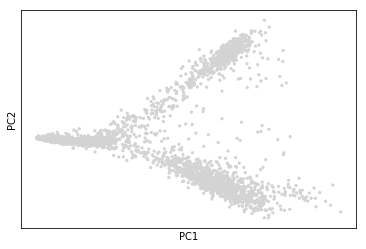

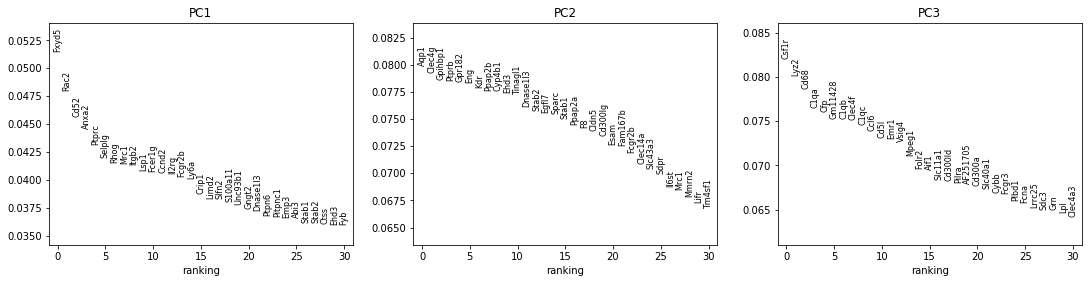

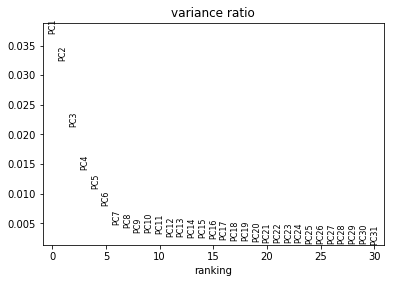

neighs & louvain
umap computing


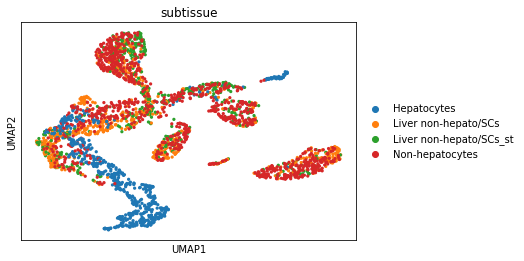

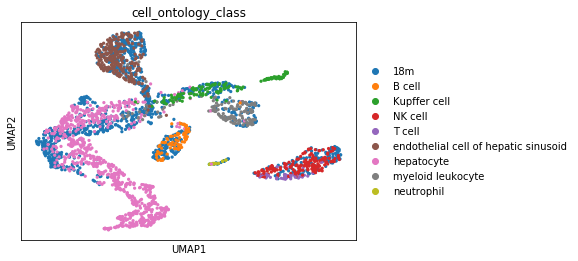

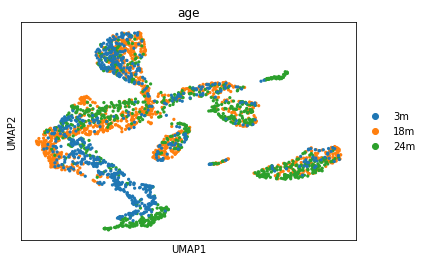

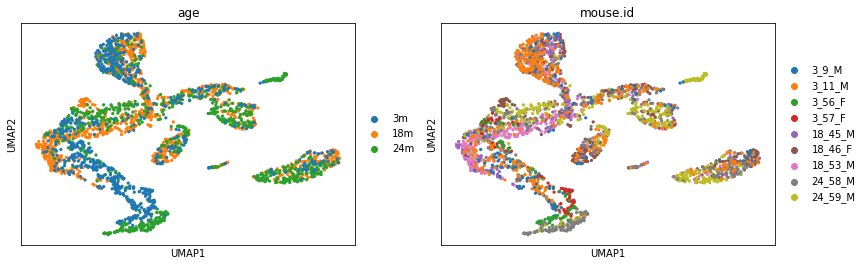

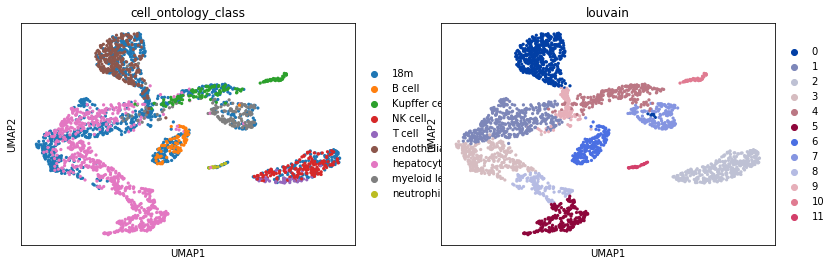

tsne computing


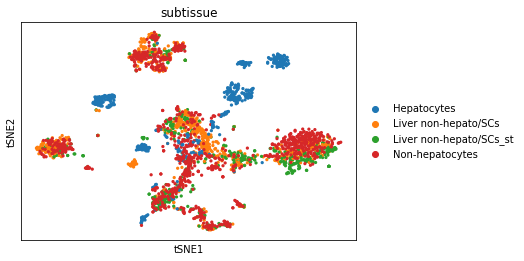

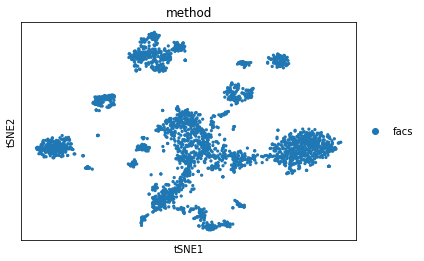

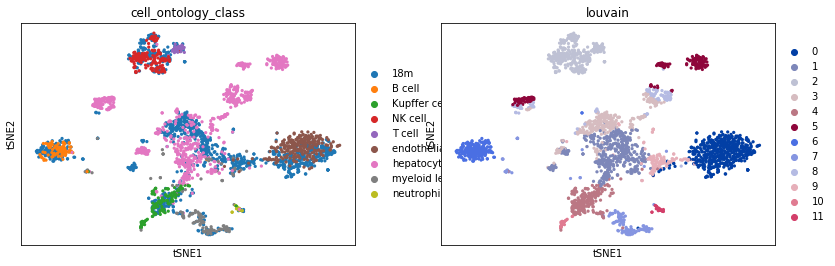

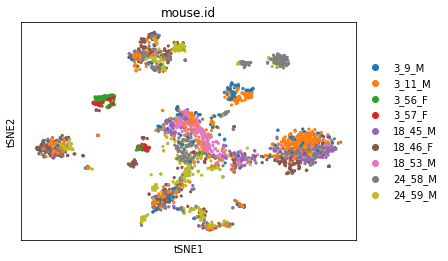

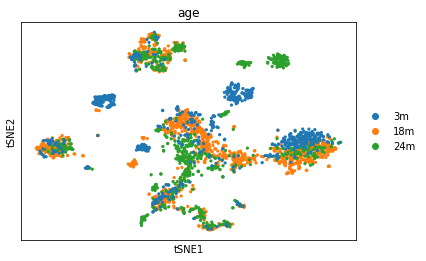

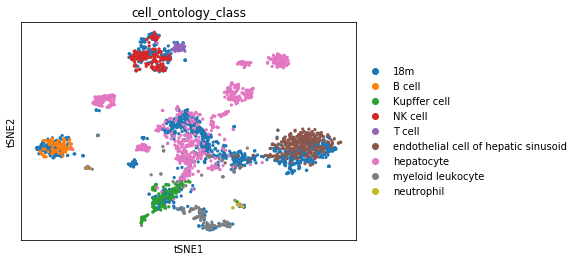

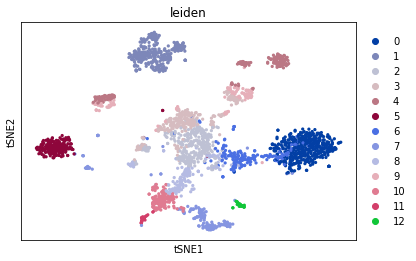

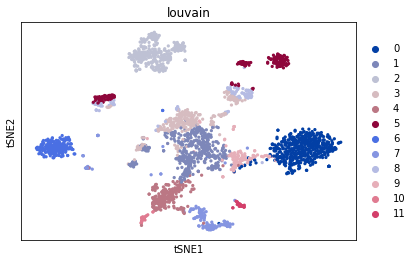

comparing to 3m & 24m data
View of AnnData object with n_obs × n_vars = 1678 × 16260 
    obs: 'FACS.selection', 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'cellid', 'free_annotation', 'method', 'mouse.id', 'plate', 'sex', 'subtissue', 'tissue', 'well', 'n_genes', 'n_counts', 'louvain', 'leiden'
    var: 'n_cells', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'pca', 'neighbors', 'louvain', 'leiden', 'subtissue_colors', 'cell_ontology_class_colors', 'age_colors', 'mouse.id_colors', 'louvain_colors', 'method_colors', 'leiden_colors'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'


... storing 'auto_cell_ontology_class' as categorical
... storing 'auto_free_annotation' as categorical
... storing 'cluster_names' as categorical


{'tbc', 'Kupffer cell', 'endothelial cell of hepatic sinusoid', 'myeloid leukocyte', 'B cell', 'hepatocyte'}
{'T cell', 'Kupffer cell', 'endothelial cell of hepatic sinusoid', 'myeloid leukocyte', 'neutrophil', 'B cell', 'NK cell', 'hepatocyte'}
{'Kupffer cell', 'endothelial cell of hepatic sinusoid', 'macrophage/DC', 'nan', 'B cell'}
Liver
mapping new annotations
{'11_tbc', '5_hepatocyte', '8_hepatocyte', '6_B cell', '3_hepatocyte', '10_Kupffer cell', '1_hepatocyte', '9_tbc', '2_tbc', '7_myeloid leukocyte', '0_endothelial cell of hepatic sinusoid', '4_tbc'}
saving graphical outputs


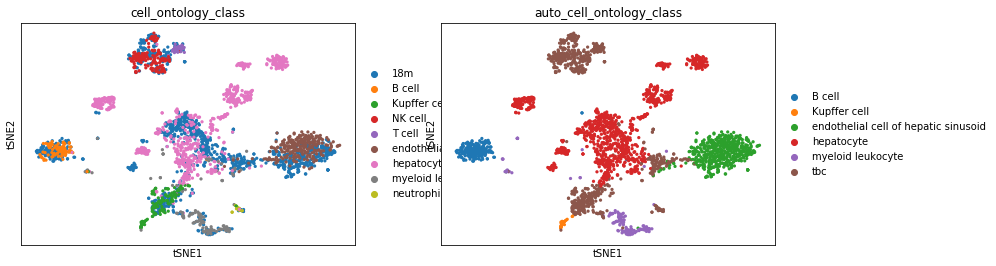

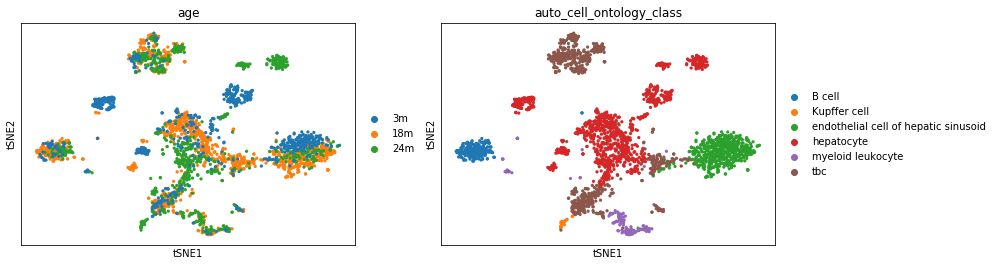

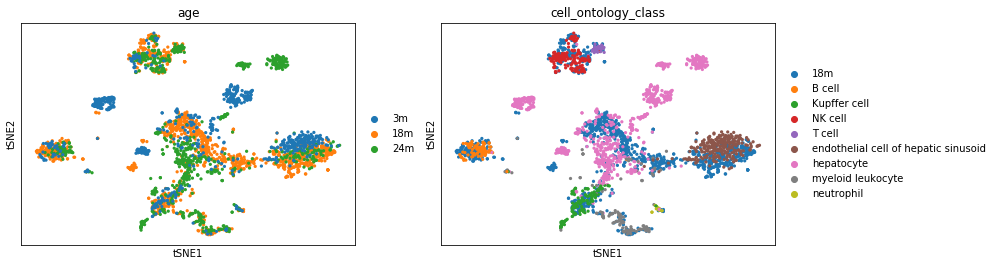

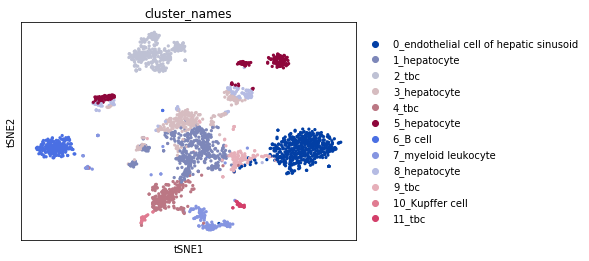

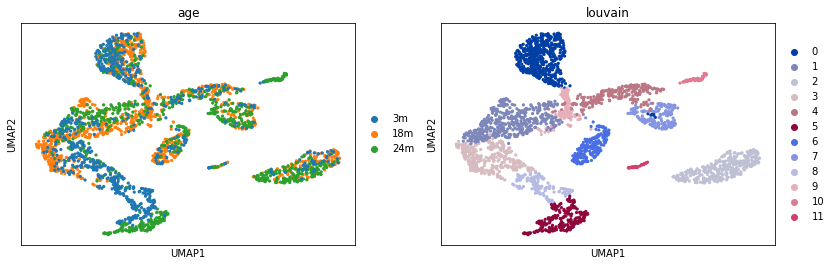

computing ranking genes


/home/ubuntu/maca-scanpy/src/scanpy/scanpy/tools/_rank_genes_groups.py:203: RuntimeWarning: overflow encountered in expm1
  foldchanges = (np.expm1(means[igroup]) + 1e-9) / (np.expm1(mean_rest) + 1e-9) #add small value to remove 0's
/home/ubuntu/maca-scanpy/src/scanpy/scanpy/tools/_rank_genes_groups.py:203: RuntimeWarning: invalid value encountered in true_divide
  foldchanges = (np.expm1(means[igroup]) + 1e-9) / (np.expm1(mean_rest) + 1e-9) #add small value to remove 0's
/home/ubuntu/maca-scanpy/src/scanpy/scanpy/tools/_rank_genes_groups.py:224: RuntimeWarning: divide by zero encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


saving object


In [11]:
for tissofinterest in list(set(adata.obs['tissue']))[9:10]:
    print('here we go again!!!')
    print(tissofinterest)
    tiss = adata[adata.obs['tissue'] == tissofinterest,:]
    print(tiss)
    
    print('preprocessing')
    sc.pp.filter_genes(tiss, min_cells=5)
    sc.pp.filter_cells(tiss, min_genes=500)
    tiss.obs['n_counts'] = np.sum(tiss.X, axis=1).A1
    tiss = tiss[tiss.obs['n_counts']>=5000]
    sc.pp.normalize_per_cell(tiss, counts_per_cell_after=1e4) #simple lib size normalization?
    tiss.raw = tiss
    tiss = sc.pp.filter_genes_dispersion(tiss, subset = False, min_disp=.5, max_disp=None, 
                              min_mean=.0125, max_mean=10, n_bins=20, n_top_genes=None, 
                              log=True, copy=True)
    sc.pp.log1p(tiss)
    sc.pp.scale(tiss, max_value=10, zero_center=False)
    
    print('pca')
    sc.tl.pca(tiss)
    sc.pl.pca_overview(tiss)
    
    print('neighs & louvain')
    sc.pp.neighbors(tiss, n_neighbors=10, n_pcs=7)
    sc.tl.louvain(tiss, resolution = .5)
    sc.tl.leiden(tiss, resolution = .5)
    
    print('umap computing')
    sc.tl.umap(tiss)
#     sc.settings.set_figure_params(dpi=200)
    try:
        sc.pl.umap(tiss, color=['subtissue'])#, save = '_'+ str(tissofinterest) +'_all-ages_facs_louvain.pdf')
    except IndexError:
        tiss.obs['subtissue'] = 'NA'
        sc.pl.umap(tiss, color=['subtissue'])#, save = '_'+ str(tissofinterest) +'_all-ages_facs_louvain.pdf')
#     sc.settings.set_figure_params(dpi=200)
    sc.pl.umap(tiss, color=['cell_ontology_class'])#, save = '_'+ str(tissofinterest) +'_all-ages_facs_louvain.pdf')
#     sc.settings.set_figure_params(dpi=200)
    sc.pl.umap(tiss, color=['age'])#, save = '_'+ str(tissofinterest) +'_all-ages_facs_louvain.pdf')
#     sc.settings.set_figure_params(dpi=200)
    sc.pl.umap(tiss, color=['age','mouse.id'])#, save = '_'+ str(tissofinterest) +'_all-ages_facs_louvain.pdf')
#     sc.settings.set_figure_params(dpi=200)
    sc.pl.umap(tiss, color=['cell_ontology_class','louvain'])#, save = '_'+ str(tissofinterest) +'_all-ages_facs_louvain.pdf')
    
    print('tsne computing')
    sc.tl.tsne(tiss, perplexity=50)
#     sc.settings.set_figure_params(dpi=200)
    sc.pl.tsne(tiss, color=['subtissue'])#, save = '_'+ str(tissofinterest) +'_all-ages_facs_tissue.pdf')
#     sc.settings.set_figure_params(dpi=200)
    sc.pl.tsne(tiss, color=['method'])#, save = '_'+ str(tissofinterest) +'_all-ages_facs_tissue.pdf')
#     sc.settings.set_figure_params(dpi=200)
    sc.pl.tsne(tiss, color=['cell_ontology_class','louvain'])#, save = '_'+ str(tissofinterest) +'_all-ages_facs_tissue.pdf')
#     sc.settings.set_figure_params(dpi=200)
    sc.pl.tsne(tiss, color=['mouse.id'])#, save = '_'+ str(tissofinterest) +'_all-ages_facs_tissue.pdf')
#     sc.settings.set_figure_params(dpi=200)
    sc.pl.tsne(tiss, color=['age'])#, save = '_'+ str(tissofinterest) +'_all-ages_facs_tissue.pdf')
#     sc.settings.set_figure_params(dpi=200)
    sc.pl.tsne(tiss, color=['cell_ontology_class'])#, save = '_'+ str(tissofinterest) +'_all-ages_facs_tissue.pdf')
    sc.pl.tsne(tiss, color=['leiden'])#, save = '_'+ str(tissofinterest) +'_all-ages_facs_tissue.pdf')
    sc.pl.tsne(tiss, color=['louvain'])#, save = '_'+ str(tissofinterest) +'_all-ages_facs_tissue.pdf')
    
    print('comparing to 3m & 24m data')
    ageofinterest = ['3m','24m']
    tissage = tiss[tiss.obs['age'].isin(ageofinterest)]
    print(tissage)
#     sc.pl.tsne(tissage, color=['cell_ontology_class','louvain'])
#     sc.pl.umap(tissage, color=['cell_ontology_class','louvain'])
#     sc.pl.umap(tissage, color=['cell_ontology_class','age'])
    tiss_cell_ontology_class = {}
    for i in set(tissage.obs['louvain']):
        df = tissage.obs[tissage.obs['louvain']==i]['cell_ontology_class']
        df.reset_index()
        df = df.reset_index()
        dfaux = df.groupby('cell_ontology_class').count()/df.groupby('cell_ontology_class').count().sum()
        dfaux.reset_index()
        dfaux = dfaux.reset_index()
        a = dfaux[dfaux['index']>0.95][['cell_ontology_class']]
        if a.empty:
            tiss_cell_ontology_class[i] = 'tbc'
        else:
            tiss_cell_ontology_class[i] = a.values[0][0]

    tiss_cell_ontology_class
    print(set(tiss_cell_ontology_class.values()))
    print(set(tissage.obs['cell_ontology_class']))

    set(tiss.obs['cell_ontology_class'])
    tiss_free_annotation = {}
    for i in set(tissage.obs['louvain']):
        df = tissage.obs[tissage.obs['louvain']==i]['free_annotation']
        df.reset_index()
        df = df.reset_index()
        dfaux = df.groupby('free_annotation').count()/df.groupby('free_annotation').count().sum()
        dfaux.reset_index()
        dfaux = dfaux.reset_index()
        a = dfaux[dfaux['index']>0.95][['free_annotation']]
        if a.empty:
            tiss_free_annotation[i] = 'nan'
        else:
            tiss_free_annotation[i] = a.values[0][0]

    tiss_free_annotation
    print(set(tiss_free_annotation.values()))
    set(tiss.obs['free_annotation'])
    new_populations = {}
    if set(tissage.obs['louvain']) != set(tiss.obs['louvain']):
        new_clusters = list(set(tiss.obs['louvain']) - set(tissage.obs['louvain']))
        for i in range(0,len(new_clusters)):
            new_populations[new_clusters[i]] = 'new-cluster'
        print(new_populations)
        tiss_cell_ontology_class = {**tiss_cell_ontology_class, **new_populations}
        tiss_free_annotation = {**tiss_free_annotation, **new_populations}

    new_populations_ages = {}
    j = 0
    print(tissofinterest)
    for i in new_populations.keys():
        j=j+1
        print(i, set(tiss.obs['age'][tiss.obs['louvain']==i]))
        new_populations_ages[j,1] = i
        new_populations_ages[j,2] = set(tiss.obs['age'][tiss.obs['louvain']==i])

    new_populations_ages
    
    print('mapping new annotations')
    tiss.obs['auto_cell_ontology_class'] = tiss.obs['louvain'].map(tiss_cell_ontology_class)
    set(tiss.obs['auto_cell_ontology_class'])
    tiss.obs['auto_free_annotation'] = tiss.obs['louvain'].map(tiss_free_annotation)
    set(tiss.obs['auto_free_annotation'])
    tiss.obs['cluster_names'] = tiss.obs['louvain'].astype(str)+'_'+tiss.obs['auto_cell_ontology_class'].astype(str)
    print(set(tiss.obs['cluster_names']))
    print('saving graphical outputs')
#     sc.pl.tsne(tiss, color=['cell_ontology_class','louvain'])
    sc.pl.tsne(tiss, color=['cell_ontology_class','auto_cell_ontology_class'])#,
#                save='_'+ str(tissofinterest) +'_all_ages_facs_cell_ontology_class_with_auto.pdf')
#     sc.pl.tsne(tiss, color=['free_annotation','auto_free_annotation'])
#     sc.pl.tsne(tiss, color=['age','free_annotation'])
    sc.pl.tsne(tiss, color=['age','auto_cell_ontology_class'])#,
#                save='_' + str(tissofinterest) + '_all-ages_facs_auto_cell_ontology_class_age.pdf')
    sc.pl.tsne(tiss, color=['age','cell_ontology_class'])#,
#                save='_' + str(tissofinterest) + '_all-ages_facs_cell_ontology_class_age.pdf')
    sc.pl.tsne(tiss, color=['cluster_names'])#,
#                save='_' + str(tissofinterest) + '_all-ages_facs_cluster_names.pdf')
    sc.pl.umap(tiss, color=['age','louvain'])#,
#                save='_' + str(tissofinterest) + '_all-ages_facs_louvain_age.pdf')
#     sc.pl.tsne(tiss[tiss.obs['auto_cell_ontology_class']=='tbc'],color = ['cell_ontology_class','louvain'])
    
    print('computing ranking genes')
    sc.tl.rank_genes_groups(tiss, 'cluster_names')#,penalty='l1')
    result = tiss.uns['rank_genes_groups']
    groups = result['names'].dtype.names
#     method = list(set(tiss.obs['method']))[0]
    tiss_cluster_genes = pd.DataFrame({group + '_' + key[:1]: result[key][group] 
                                   for group in groups for key in ['names', 'scores']})
#     sc.pl.rank_genes_groups(tiss, n_genes=20)
    
    print('saving object')
#     tiss.write('../anndata-objs/'+tissofinterest+'_facs_processed.h5ad')
#     tiss_cluster_genes.to_csv('../anndata-objs/'+tissofinterest+'_facs_rank_genes.csv')

In [ ]:
set(tissage.obs['age'])

In [ ]:
sc.pl.umap(tissage,color='age')

In [ ]:
sc.pl.pca_variance_ratio(tiss, log=True)

In [ ]:
sc.pl.pca_overview(tiss)

In [ ]:
tissage[tissage.obs['free_annotation']=='nan']